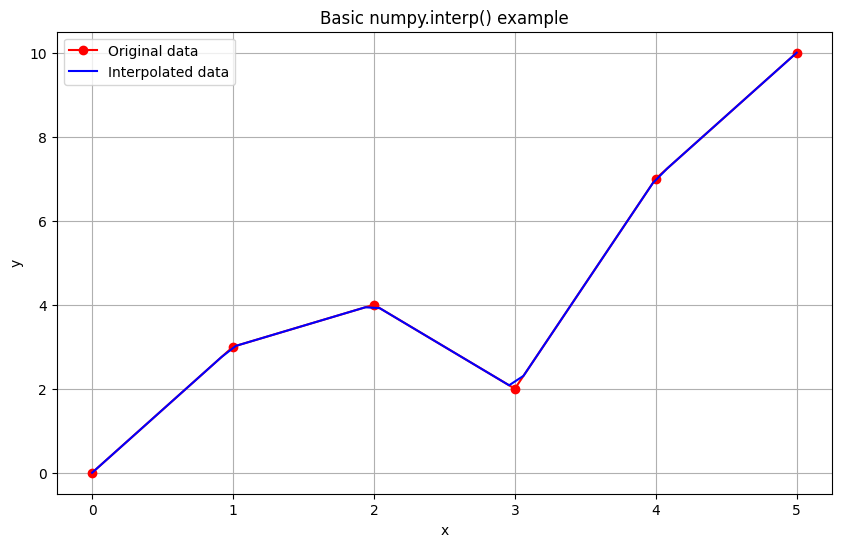

65536


In [1]:
## Demonstrating numpy.interp() function

import numpy
import matplotlib.pyplot as plt
%matplotlib inline

### Basic Usage of numpy.interp()

# Define known x and y values
x = numpy.array([0, 1, 2, 3, 4, 5])
y = numpy.array([0, 3, 4, 2, 7, 10])

# Define x values to interpolate
x_interp = numpy.linspace(0, 5, 50)

# Perform interpolation
y_interp = numpy.interp(x_interp, x, y)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'ro-', label='Original data')
plt.plot(x_interp, y_interp, 'b-', label='Interpolated data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Basic numpy.interp() example')
plt.legend()
plt.grid(True)
plt.show()

from IMOSPATools import rawdat
print(1 << rawdat.BITS_PER_SAMPLE)


calFreq=[0.000e+00 1.000e+00 2.000e+00 ... 2.998e+03 2.999e+03 3.000e+03]


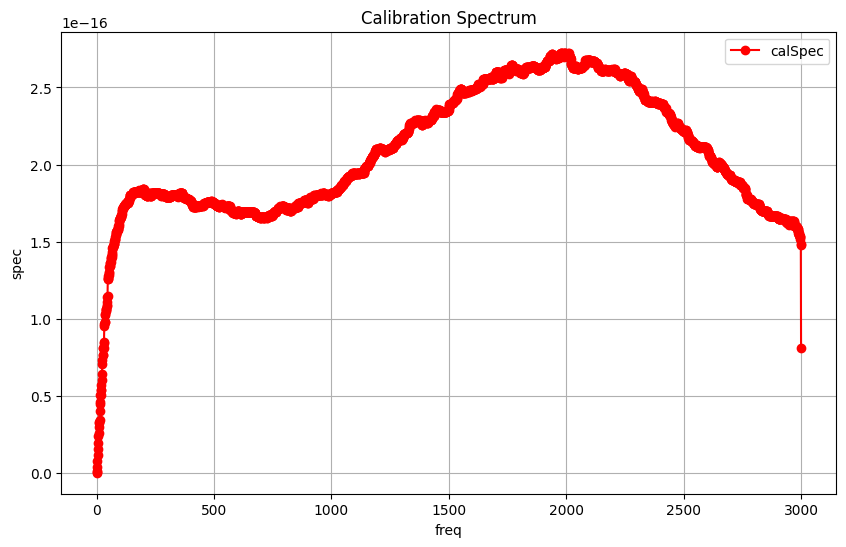

In [2]:
### test calibration spectrum interoplation
import scipy
from IMOSPATools import rawdat
from IMOSPATools import calibration

fileName = "../scripts/501E9BF5.DAT"
calSpec, calFreq, fSample = calibration.loadPrepCalibFile(fileName, -90.0, -197.8)

print(f"calFreq={calFreq}")

# Plot the calibration spectrum
plt.figure(figsize=(10, 6))
plt.plot(calFreq, calSpec, 'ro-', label='calSpec')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('Calibration Spectrum')
plt.legend()
plt.grid(True)
plt.show()

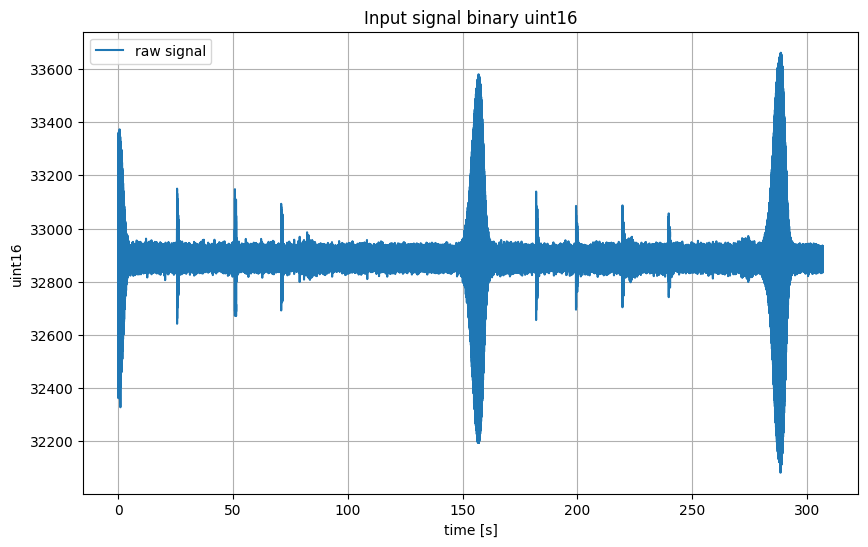

binData min: 32082 max: 33661


In [3]:
rawFileName = "../scripts/502DB01D.DAT"
binData, numChannels, sampleRate, durationHeader, \
        startTime, endTime = rawdat.readRawFile(rawFileName)
x = numpy.arange(0, (binData.size)/sampleRate, (1/sampleRate))
from scipy.ndimage import uniform_filter1d

window_size = 2000  # Adjust this value to change the smoothing level
# Plot the Volts
plt.figure(figsize=(10, 6))
plt.plot(x, binData, linestyle='-', label='raw signal')
plt.xlabel('time [s]')
plt.ylabel('uint16')
plt.title('Input signal binary uint16')
plt.legend()
plt.grid(True)
plt.show()

print(f"binData min: {numpy.min(binData)} max: {numpy.max(binData)}")

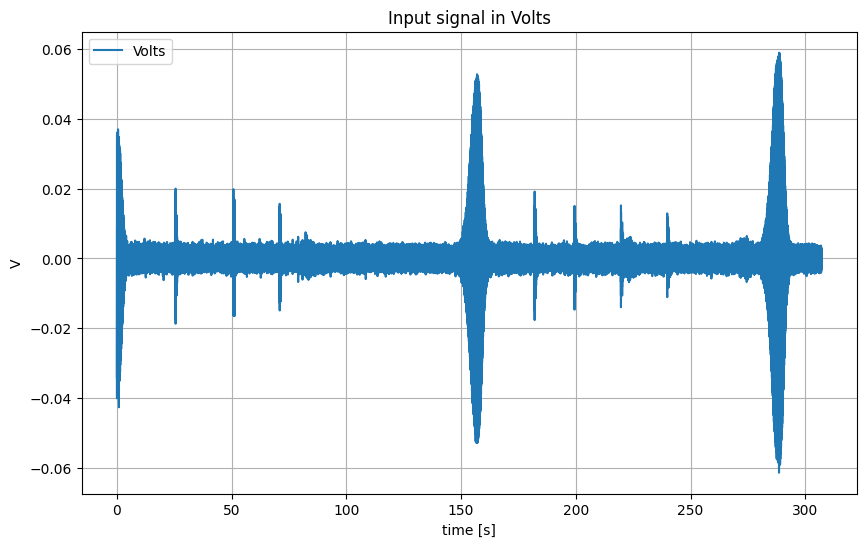

In [4]:
volts = calibration.toVolts(binData)
x = numpy.arange(0, (volts.size)/sampleRate, (1/sampleRate))
# Calculate moving average - just for plotting
window_size = 2001  # Adjust this value to change the smoothing level

# Plot the Volts
plt.figure(figsize=(10, 6))
plt.plot(x, volts, linestyle='-', label='Volts')
plt.xlabel('time [s]')
plt.ylabel('V')
plt.title('Input signal in Volts')
plt.legend()
plt.grid(True)
plt.show()

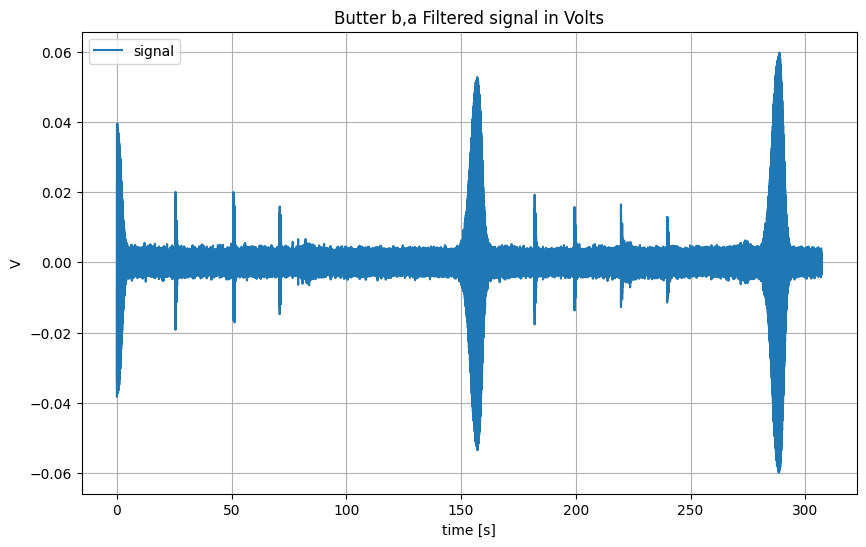

In [5]:
# make high-pass filter to remove slow varying DC offset
b, a = scipy.signal.butter(5, 5/fSample*2, btype='high', output='ba')
# apply the filter on the input signal
signal = scipy.signal.lfilter(b, a, volts)

# Plot the Volts
plt.figure(figsize=(10, 6))
plt.plot(x, signal, linestyle='-', label='signal')
plt.xlabel('time [s]')
plt.ylabel('V')
plt.title('Butter b,a Filtered signal in Volts')
plt.legend()
plt.grid(True)
plt.show()

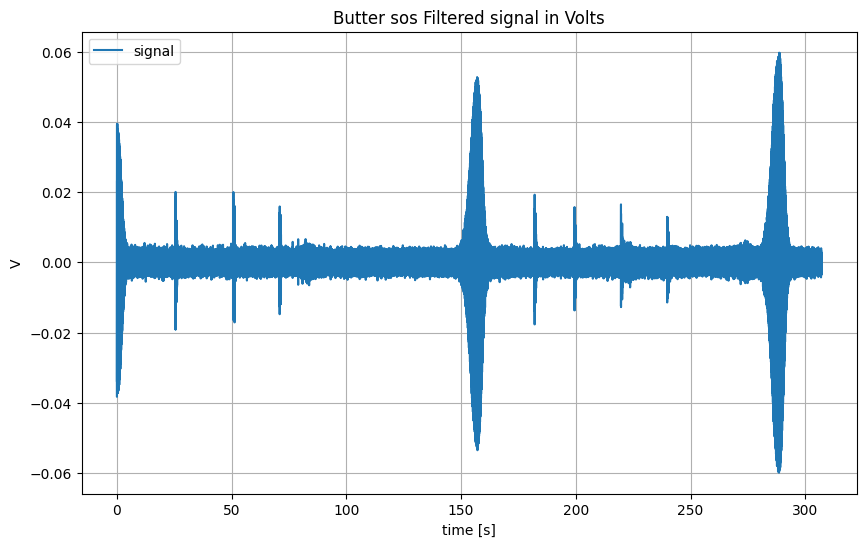

In [6]:
# make high-pass filter to remove slow varying DC offset
sos = scipy.signal.butter(5, 5/fSample*2, btype='high', output='sos')
# apply the filter on the input signal
signal2 = scipy.signal.sosfilt(sos, volts)

# Calculate moving average - just for plotting
y_avg = uniform_filter1d(signal2, size=window_size)
# Plot the Volts
plt.figure(figsize=(10, 6))
plt.plot(x, signal2, linestyle='-', label='signal')
plt.xlabel('time [s]')
plt.ylabel('V')
plt.title('Butter sos Filtered signal in Volts')
plt.legend()
plt.grid(True)
plt.show()

fmax=3000.0


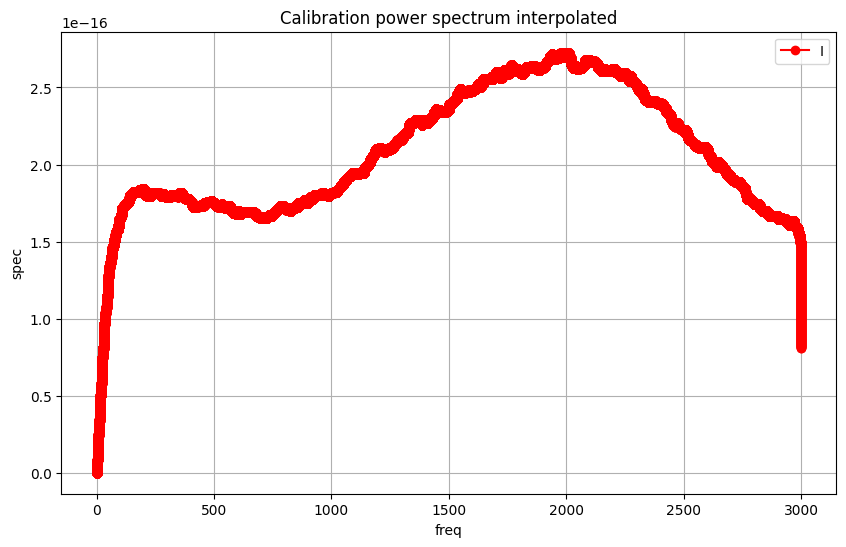

In [7]:
fmax = calFreq[len(calFreq) - 1]
print(f"fmax={fmax}")
df = fmax * 2 / len(signal)
# generate a set of frequencies as ndarray
freqFFT = numpy.arange(0, fmax + df, df)

# MC note: the interpolation function numpy.interp() has a different
#          params order compared with matlab function interp1()
calSpecInt = numpy.interp(freqFFT, calFreq, calSpec)

plt.figure(figsize=(10, 6))
plt.plot(freqFFT, calSpecInt, 'ro-', label='calSpec')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('Calibration power spectrum interpolated')
plt.legend('Interpolated Spectrum')
plt.grid(True)
plt.show()

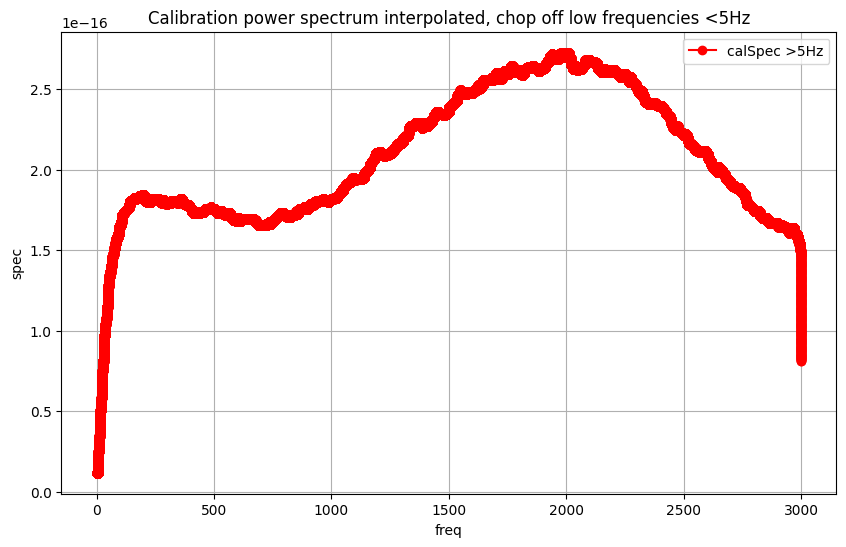

In [8]:
# Ignore calibration values below 5 Hz to avoid inadequate correction
N5Hz = numpy.where(freqFFT <= 5)[0]
calSpecInt[N5Hz] = calSpecInt[N5Hz[-1]]

plt.figure(figsize=(10, 6))
plt.plot(freqFFT, calSpecInt, 'ro-', label='calSpec >5Hz')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('Calibration power spectrum interpolated, chop off low frequencies <5Hz')
plt.legend()
plt.grid(True)
plt.show()

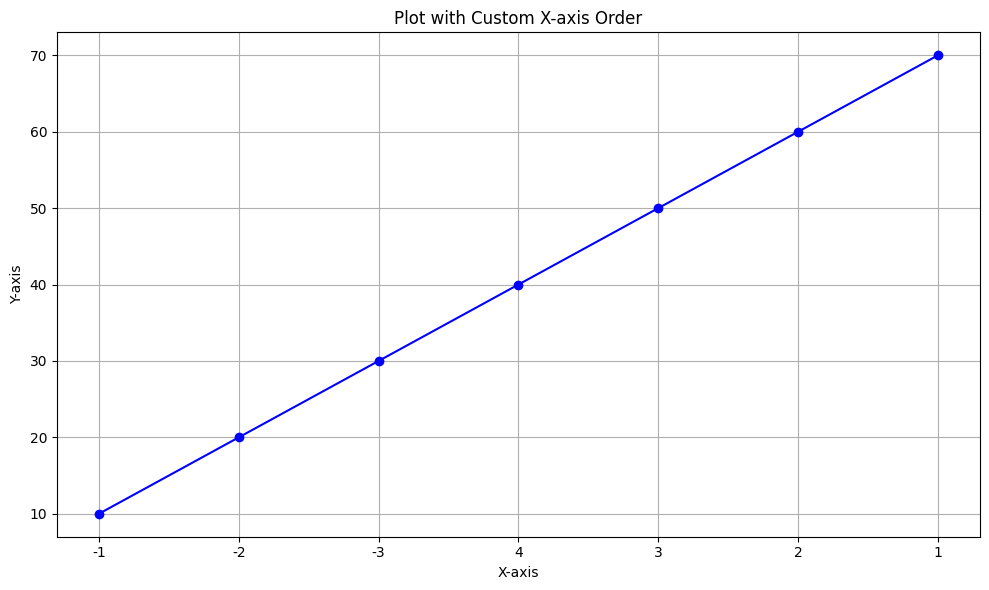

In [9]:
import matplotlib.pyplot as plt
import numpy as numpy

# Create data with specific x-axis order
x = numpy.array([-1, -2, -3, 4, 3, 2, 1])
y = numpy.array([10, 20, 30, 40, 50, 60, 70])

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data using the index of x as the x-coordinate
ax.plot(range(len(x)), y, 'bo-')

# Set the actual x values as tick labels
ax.set_xticks(range(len(x)))
ax.set_xticklabels(x)

# Add labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Plot with Custom X-axis Order')

# Show the grid
ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [25]:
import numpy
spec = numpy.fft.fft(signal)

print(spec.size)
print(signal.size/spec.size)

# filter out < 5Hz
print(5.0/(3000.0 * 2))
print(5.0/(3000.0 * 2) * spec.size)
print(numpy.ceil((5.0/(3000.0 * 2)) * spec.size))

zeroTo5Hz_numSamples = int(numpy.ceil((5.0/(3000.0 * 2)) * spec.size))

print(zeroTo5Hz_numSamples)

print(f"before clearing <5Hz {spec[zeroTo5Hz_numSamples//2]}, {spec[10000]}, {spec[-(zeroTo5Hz_numSamples//2)]}")

spec[:zeroTo5Hz_numSamples] = 0.0 + 0.0j
spec[-zeroTo5Hz_numSamples:] = 0.0 + 0.0j

print(f"after clearing <5Hz {spec[zeroTo5Hz_numSamples//2]}, {spec[10000]}, {spec[-(zeroTo5Hz_numSamples//2)]}")


1842224
1.0
0.0008333333333333334
1535.1866666666667
1536.0
1536
before clearing <5Hz (0.09993769300167876-0.11508185763764095j), (-5.769917615743286+1.1966659669689665j), (0.0999376930016791+0.11508185763764023j)
after clearing <5Hz 0j, (-5.769917615743286+1.1966659669689665j), 0j


1842224
1833008
[-3000.         -2999.99674307 -2999.99348613 ...  2999.98697227
  2999.9902292   2999.99348613]


/home/martin/miniconda3/envs/imos-3.9/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


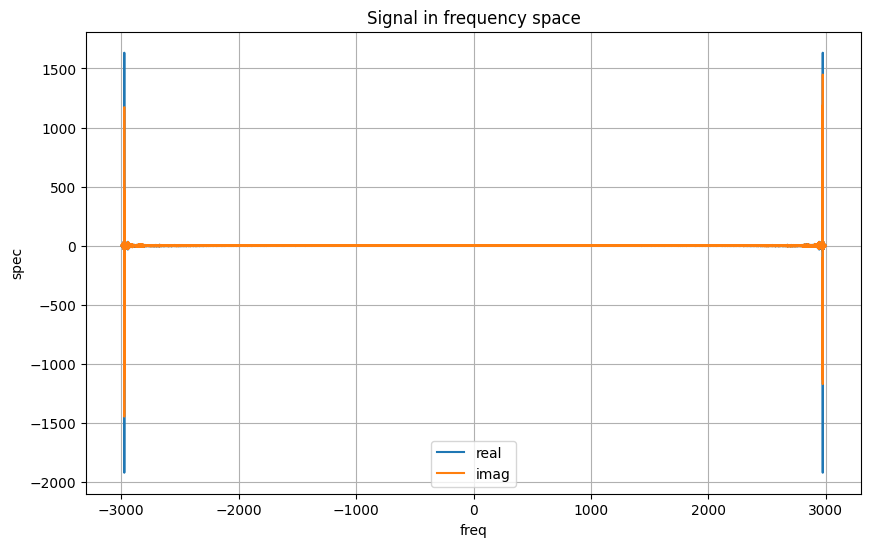

In [11]:

#x = numpy.concatenate((-1 * (freqFFT[0:-1]), (freqFFT[::-1][:-1])))
#print(len(x))
#print(x)

x = numpy.concatenate((-1 * (freqFFT[::-1]), (freqFFT[:-2])))
print(len(x))
print(len(x[zeroTo5Hz_numSamples*3:-zeroTo5Hz_numSamples*3]))
print(x)

#fig, ax = plt.subplots(figsize=(10, 6))
## Plot the data using the index of x as the x-coordinate
## ax.plot(x, spec.real, linestyle='-', label='real')
#ax.plot(range(len(x)), spec.real, 'bo-')
## ax.plot(x, spec.imag, linestyle='-', label='imag')
## Set the actual x values as tick labels
#ax.set_xticks(range(len(x)))
#ax.set_xticklabels(x)
## Add labels and title
#ax.set_xlabel('freq')
#ax.set_ylabel('spec')
#ax.set_title('Signal in frequency space')
## Show the grid
#ax.grid(True)
##ax.legend()
## Show the plot
#plt.tight_layout()
#plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, spec.real, linestyle='-', label='real')
plt.plot(x, spec.imag, linestyle='-', label='imag')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('Signal in frequency space')
plt.legend()
plt.grid(True)
# plt.ylim(-30, 30)
plt.show()

[-2959.97880822 -2959.97555129 -2959.97229436 ...  2959.96578049
  2959.96903742  2959.97229436]
[ 3.67763888-5.78139496j  6.66396826+4.52038396j -2.86479005-6.53987943j
 ...  4.15754606+6.56776009j -2.86479005+6.53987943j
  6.66396826-4.52038396j]


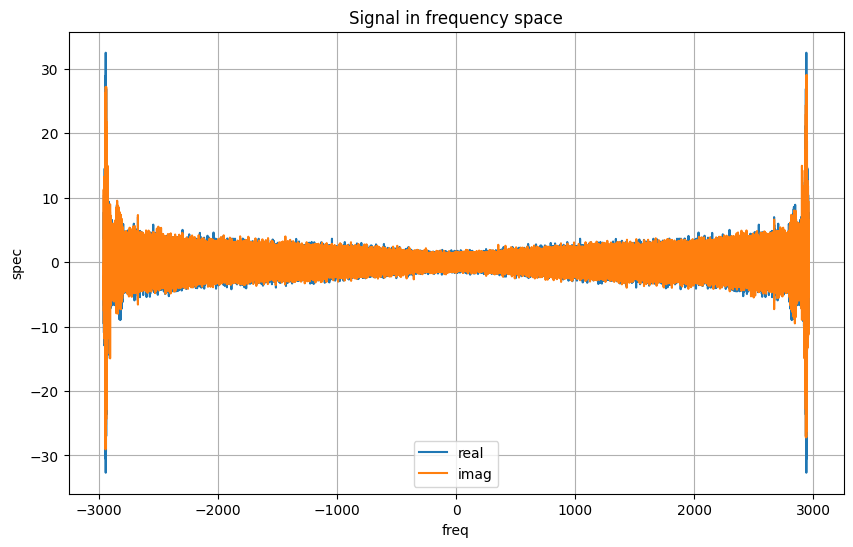

In [12]:
plt.figure(figsize=(10, 6))

x1 = x[(zeroTo5Hz_numSamples*8):-(zeroTo5Hz_numSamples*8)]
print(x1)
y1 = spec[(zeroTo5Hz_numSamples*8):-(zeroTo5Hz_numSamples*8)]
print(y1)

plt.plot(x1, y1.real, linestyle='-', label='real')
plt.plot(x1, y1.imag, linestyle='-', label='imag')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('Signal in frequency space')
plt.legend()
plt.grid(True)
# plt.xlim(0, zeroTo5Hz_numSamples * 5)
# plt.xlim(-2972, 2972)
plt.show()

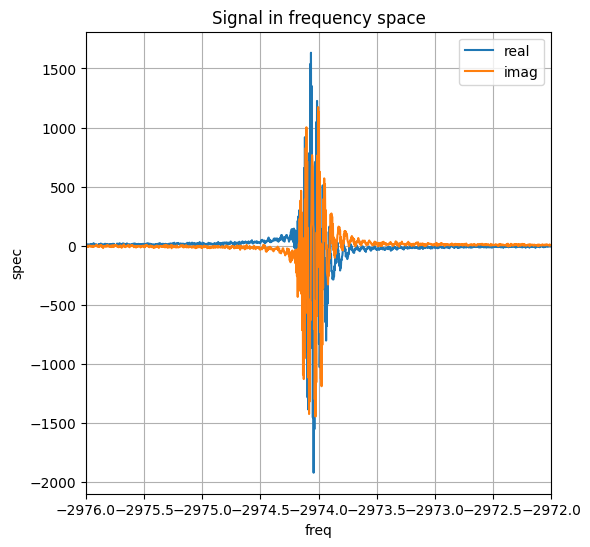

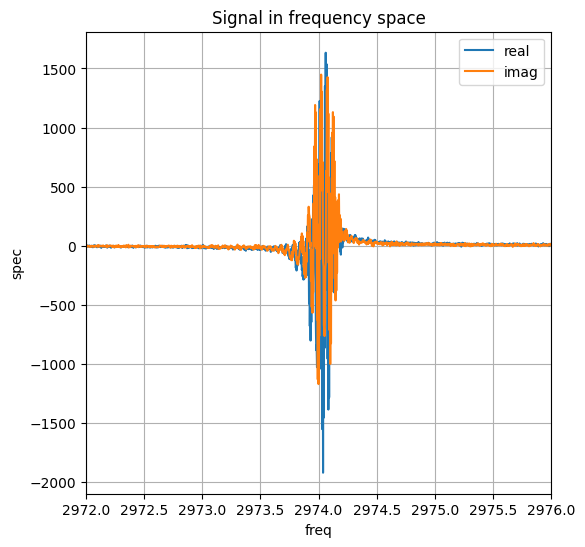

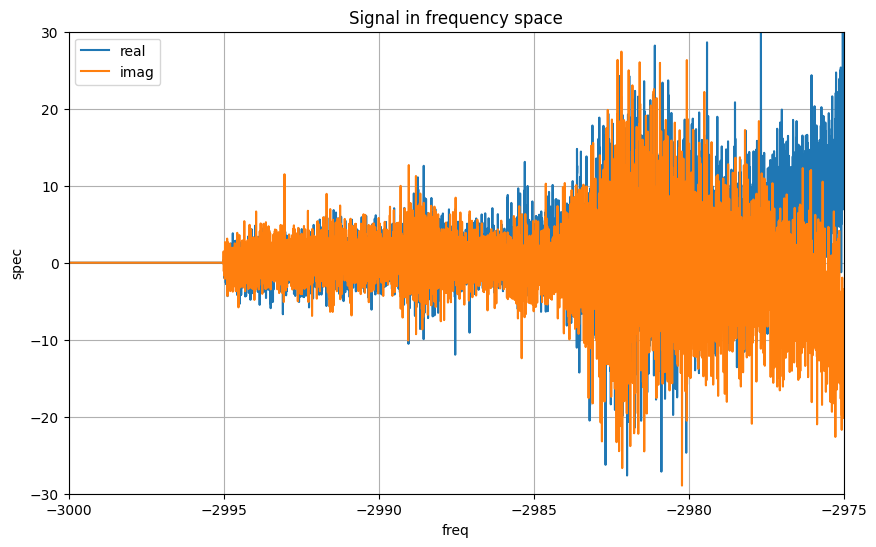

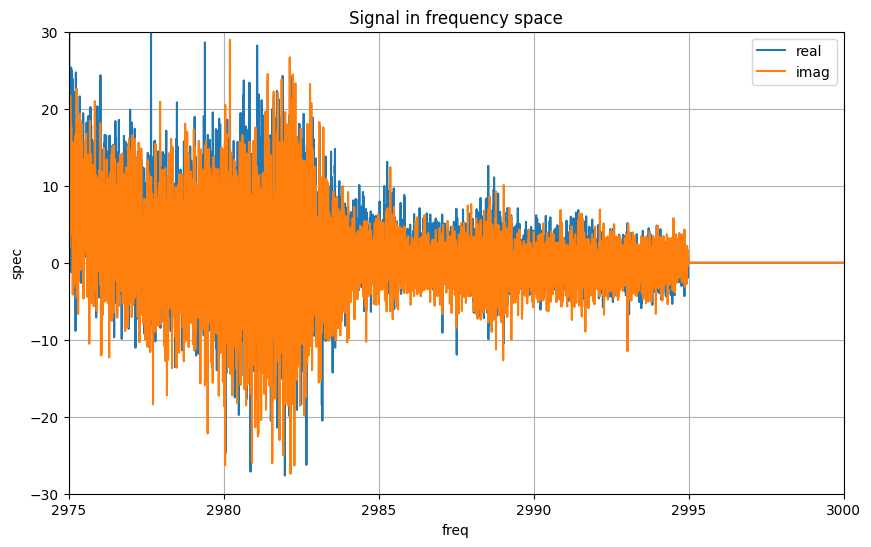

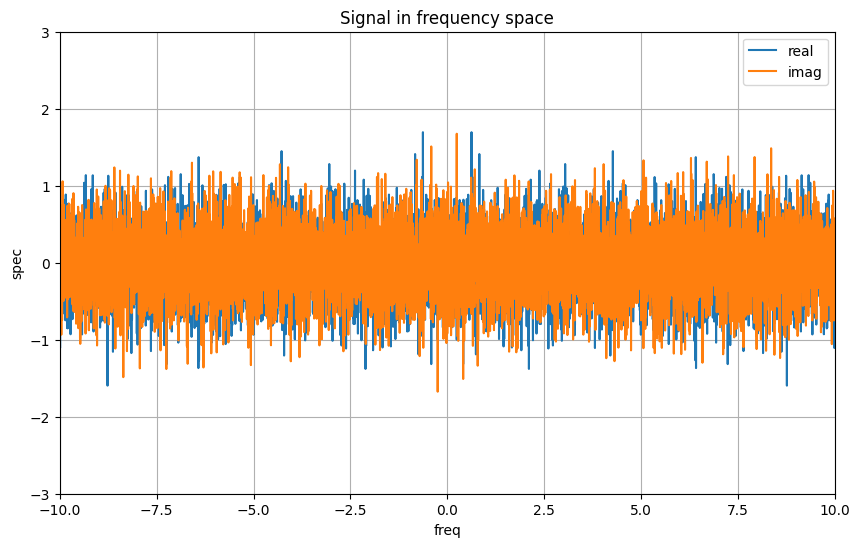

In [13]:
x = numpy.concatenate((-1 * (freqFFT[::-1]), (freqFFT[:-2])))

plt.figure(figsize=(6, 6))
plt.plot(x, spec.real, linestyle='-', label='real')
plt.plot(x, spec.imag, linestyle='-', label='imag')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('Signal in frequency space')
plt.legend()
plt.grid(True)
# plt.xlim(0, zeroTo5Hz_numSamples * 5)
plt.xlim(-2976, -2972)
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(x, spec.real, linestyle='-', label='real')
plt.plot(x, spec.imag, linestyle='-', label='imag')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('Signal in frequency space')
plt.legend()
plt.grid(True)
# plt.xlim(0, zeroTo5Hz_numSamples * 5)
plt.xlim(2972, 2976)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, spec.real, linestyle='-', label='real')
plt.plot(x, spec.imag, linestyle='-', label='imag')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('Signal in frequency space')
plt.legend()
plt.grid(True)
plt.ylim(-30, 30)
# plt.xlim(0, zeroTo5Hz_numSamples * 5)
plt.xlim(-3000, -2975)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, spec.real, linestyle='-', label='real')
plt.plot(x, spec.imag, linestyle='-', label='imag')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('Signal in frequency space')
plt.legend()
plt.grid(True)
plt.ylim(-30, 30)
# plt.xlim(0, zeroTo5Hz_numSamples * 5)
plt.xlim(2975, 3000)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, spec.real, linestyle='-', label='real')
plt.plot(x, spec.imag, linestyle='-', label='imag')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('Signal in frequency space')
plt.legend()
plt.grid(True)
plt.ylim(-3, 3)
# plt.xlim(0, zeroTo5Hz_numSamples * 5)
plt.xlim(-10, 10)
plt.show()

1842224
1.0


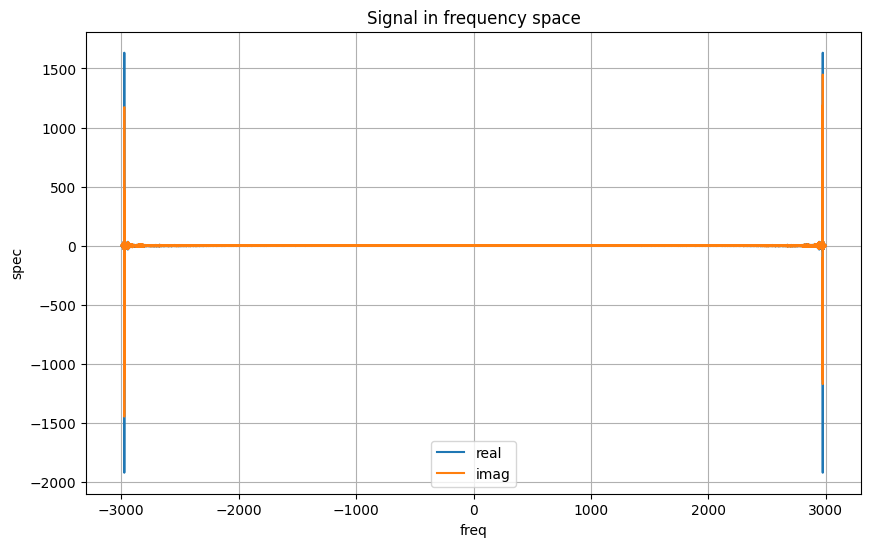

In [14]:

print(spec.size)
print(signal.size/spec.size)

# x = numpy.arange(0, spec.size, 1)

plt.figure(figsize=(10, 6))
plt.plot(x, spec.real, linestyle='-', label='real')
plt.plot(x, spec.imag, linestyle='-', label='imag')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('Signal in frequency space')
plt.legend()
plt.grid(True)
plt.show()

pwr spectrum DC offset 1.174581566453106e-17
pwr spectrum Nyquist freq 8.12012404443555e-17


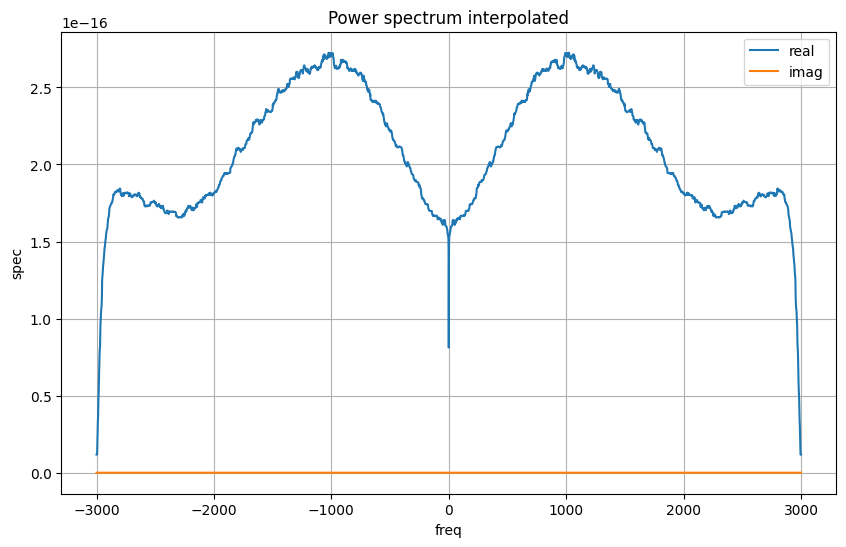

In [15]:
if len(signal) % 2 == 0:
    # off mumber of samples
    # calibratedSignal = numpy.fft.ifft(spec / numpy.sqrt(numpy.concatenate((calSpecInt[1:], calSpecInt[::-1][1:]))))
    pwrSpec = numpy.concatenate((calSpecInt[0:-1], calSpecInt[::-1][:-1]))
    print(f'pwr spectrum DC offset {pwrSpec[0]}') 
    print(f'pwr spectrum Nyquist freq {pwrSpec[pwrSpec.size//2]}') 
    #log.debug(f'pwr spectrum real end {pwrSpec[-3:][::-1].real}')
    #log.debug(f'pwr spectrum imag beg {pwrSpec[0:3].imag}')
    #log.debug(f'pwr spectrum imag end {pwrSpec[-3:][::-1].imag}')
else:
    # even mumber of samples
    # calibratedSignal = numpy.fft.ifft(spec / numpy.sqrt(numpy.concatenate((calSpecInt, calSpecInt[::-1][1:]))))
    pwrSpec = numpy.concatenate((calSpecInt[0:-1], calSpecInt[::-1][:-1]))

# x = numpy.arange(0, pwrSpec.size, 1)

plt.figure(figsize=(10, 6))
plt.plot(x, pwrSpec.real, linestyle='-', label='real')
plt.plot(x, pwrSpec.imag, linestyle='-', label='imag')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('Power spectrum interpolated')
plt.legend()
plt.grid(True)
plt.show()

specToInverse.size = 1842224


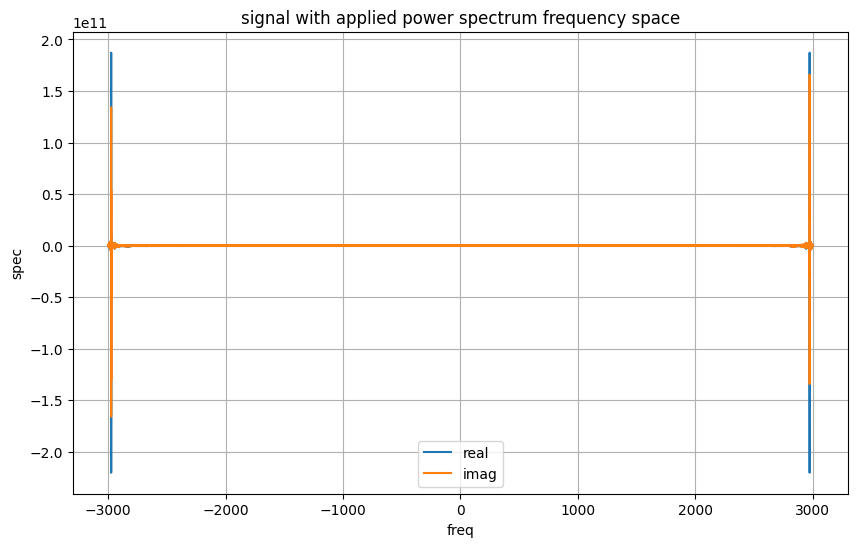

In [16]:
specToInverse = spec / numpy.sqrt(pwrSpec)
print(f"specToInverse.size = {specToInverse.size}")

# x = numpy.arange(0, specToInverse.size, 1)

plt.figure(figsize=(10, 6))
plt.plot(x, specToInverse.real, linestyle='-', label='real')
plt.plot(x, specToInverse.imag, linestyle='-', label='imag')
plt.xlabel('freq')
plt.ylabel('spec')
plt.title('signal with applied power spectrum frequency space')
plt.legend()
plt.grid(True)
plt.show()

Calibrated signal after IFFT contains non-zero imaginary component(s)


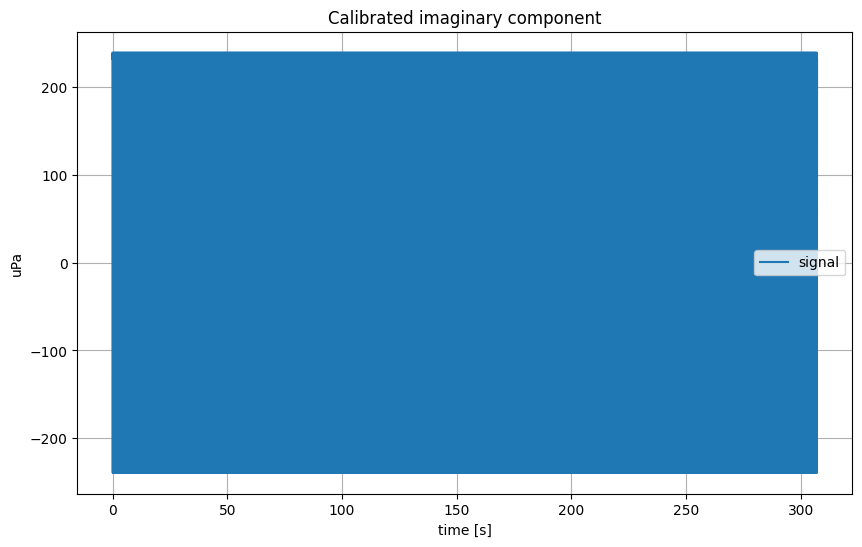

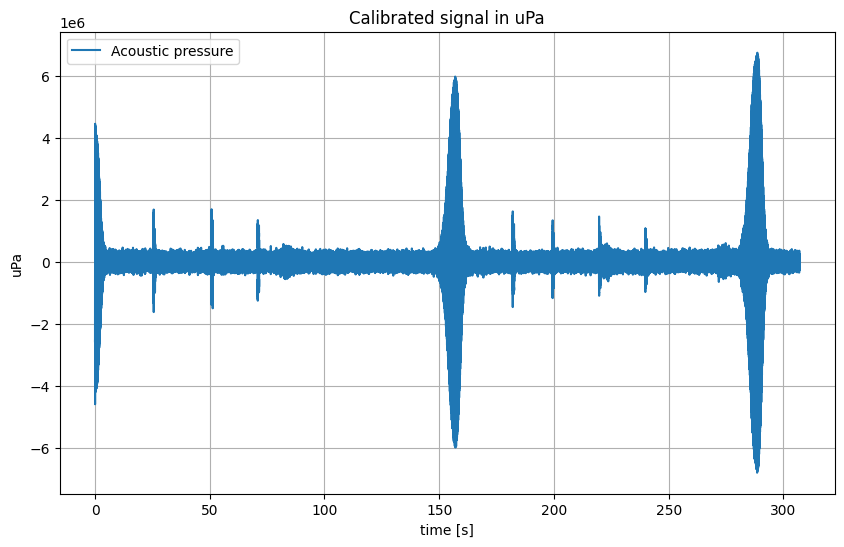

In [23]:
calibratedSignal = numpy.fft.ifft(specToInverse)

x = numpy.arange(0, (calibratedSignal.size)/sampleRate, (1/sampleRate))

if not numpy.allclose(calibratedSignal.imag, 0.0):
    logMsg = "Calibrated signal after IFFT contains non-zero imaginary component(s)"
    print(logMsg)
    
    
# Plot the Volts
plt.figure(figsize=(10, 6))
plt.plot(x, calibratedSignal.imag, linestyle='-', label='signal')
plt.xlabel('time [s]')
plt.ylabel('uPa')
plt.title('Calibrated imaginary component')
plt.legend()
plt.grid(True)
plt.show()

# explicitly cut off the imaginary component
# Perhaps the signed size of the complex number as vector would be more accurate?
calibratedSignal = calibratedSignal.real

plt.figure(figsize=(10, 6))
plt.plot(x, calibratedSignal, linestyle='-', label='Acoustic pressure')
plt.xlabel('time [s]')
plt.ylabel('uPa')
plt.title('Calibrated signal in uPa')
plt.legend()
plt.grid(True)
plt.show()

Maximum abs amplitude of the calibrated signal before scaling: 6812928.230618298
Scale factor to reconstruct normalised signal is: 10000000.0
Maximum abs amplitude of the normalised/scaled signal: 0.6812928230618298


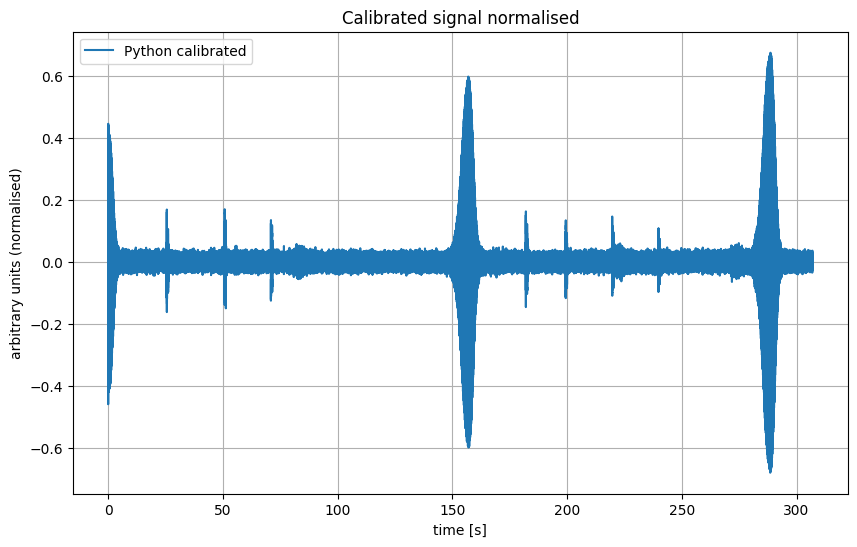

In [18]:
print(f"Maximum abs amplitude of the calibrated signal before scaling: {numpy.max(numpy.abs(calibratedSignal))}")

# scaling as per Sasha's matlab code
scaleFactor = 10 ** numpy.ceil(numpy.log10(numpy.max(numpy.abs(calibratedSignal))))
normalisedSignal = calibratedSignal / scaleFactor
print(f"Scale factor to reconstruct normalised signal is: {scaleFactor}")
print(f"Maximum abs amplitude of the normalised/scaled signal: {numpy.max(numpy.abs(normalisedSignal))}")

plt.figure(figsize=(10, 6))
plt.plot(x, normalisedSignal, linestyle='-', label='Python calibrated')
plt.xlabel('time [s]')
plt.ylabel('arbitrary units (normalised)')
plt.title('Calibrated signal normalised')
plt.legend()
plt.grid(True)
plt.show()

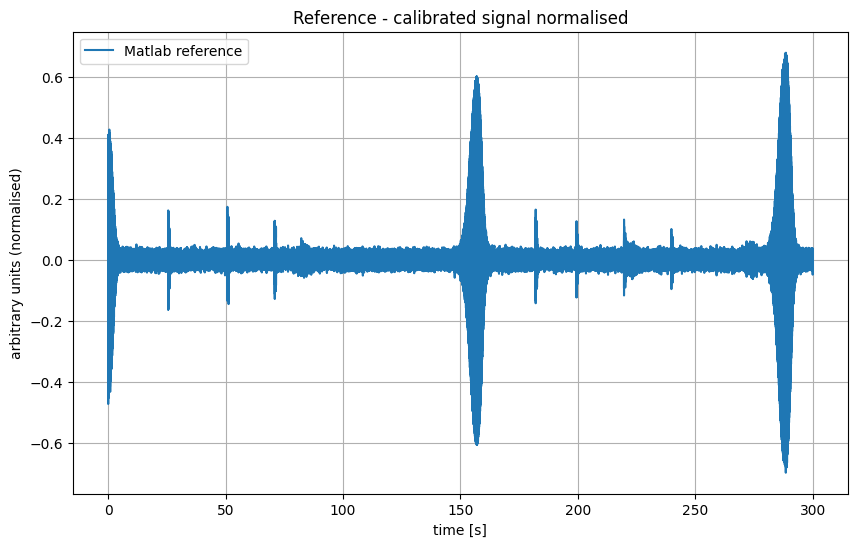

In [19]:
refFName = "../tests/data/Rottnest_3154/reference/502DB01D_normalised.TXT"
ref_normalised = numpy.loadtxt(refFName, dtype=float)

x = numpy.arange(0, (ref_normalised.size)/sampleRate, (1/sampleRate))

plt.figure(figsize=(10, 6))
plt.plot(x, ref_normalised, linestyle='-', label='Matlab reference')
plt.xlabel('time [s]')
plt.ylabel('arbitrary units (normalised)')
plt.title('Reference - calibrated signal normalised')
plt.legend()
plt.grid(True)
plt.show()

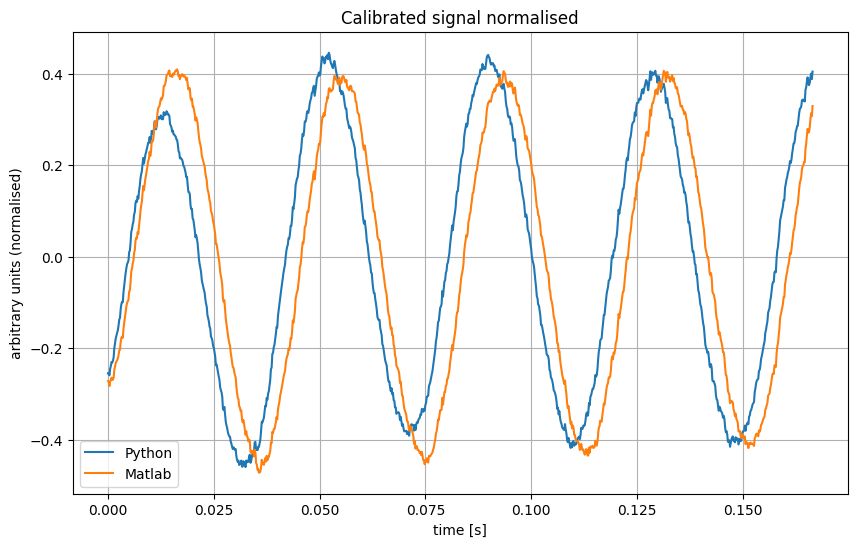

N1=179000, N2=180000
len(pyth)=1000
len(matl)=1000


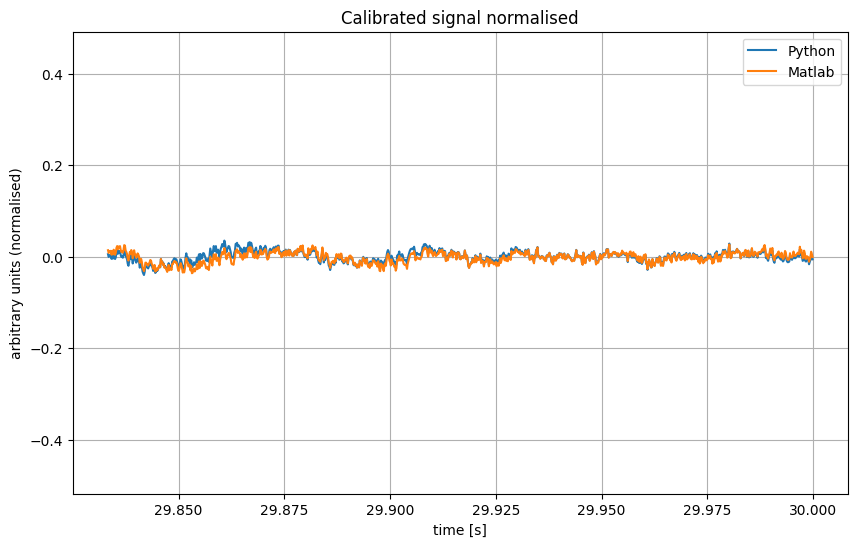

N1=215000, N2=216000
len(pyth)=1000
len(matl)=1000


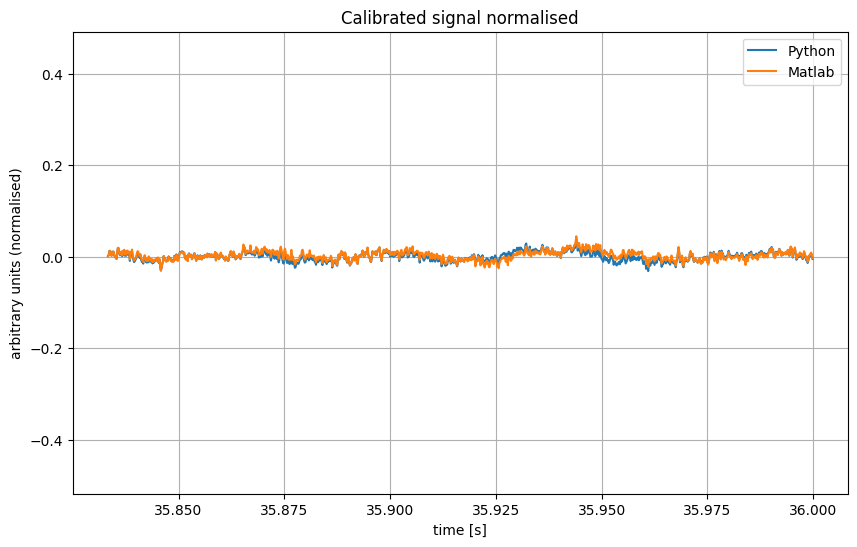

N1=251000, N2=252000
len(pyth)=1000
len(matl)=1000


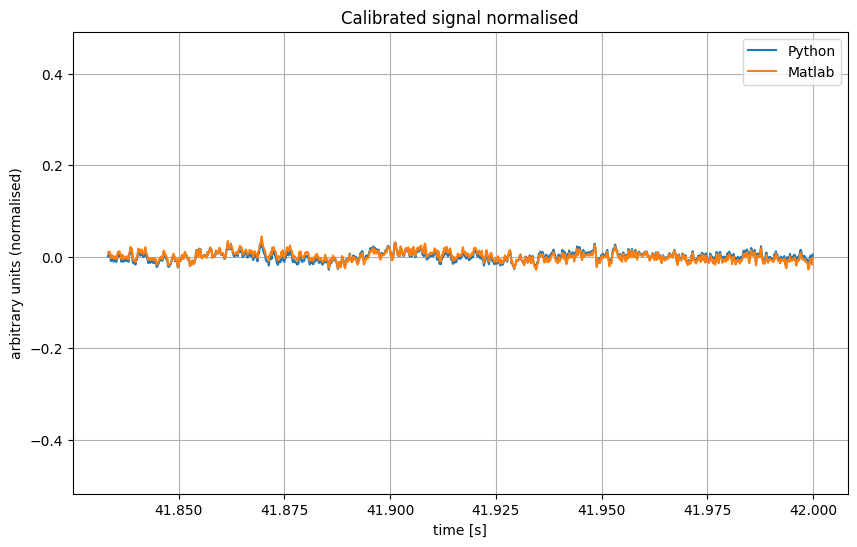

N1=287000, N2=288000
len(pyth)=1000
len(matl)=1000


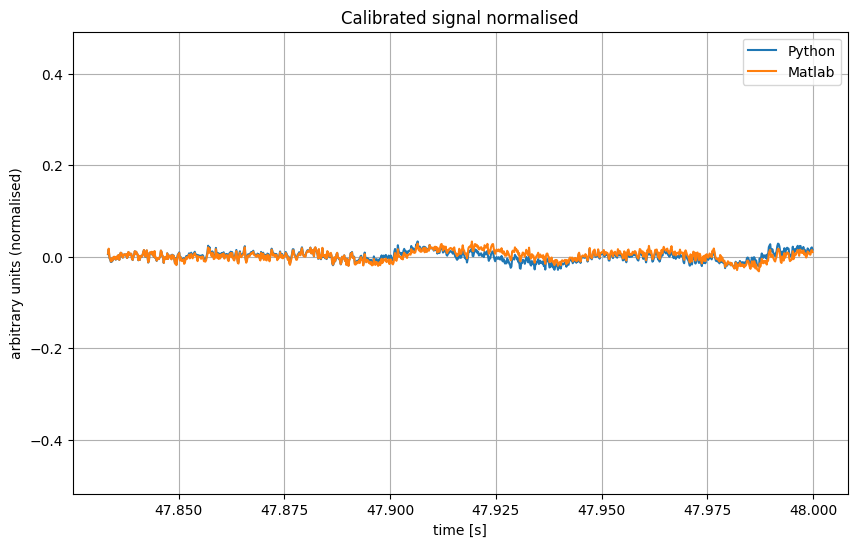

N1=323000, N2=324000
len(pyth)=1000
len(matl)=1000


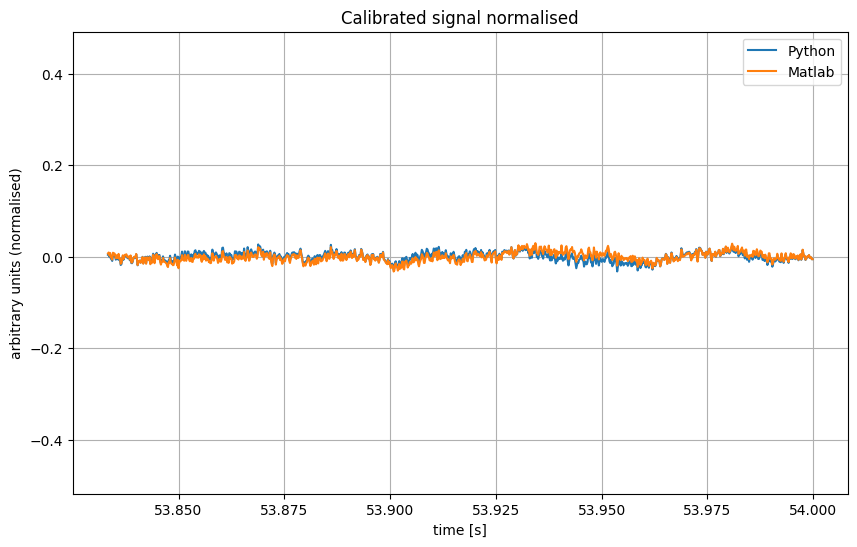

N1=359000, N2=360000
len(pyth)=1000
len(matl)=1000


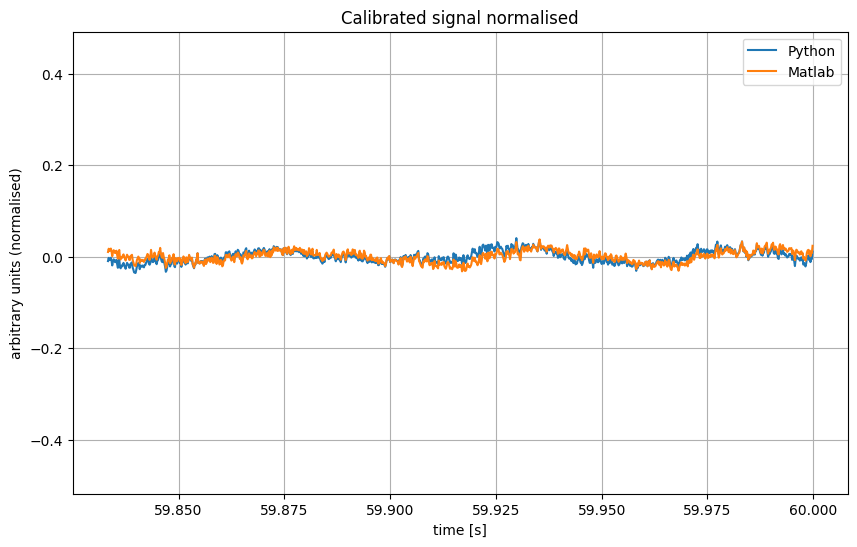

N1=395000, N2=396000
len(pyth)=1000
len(matl)=1000


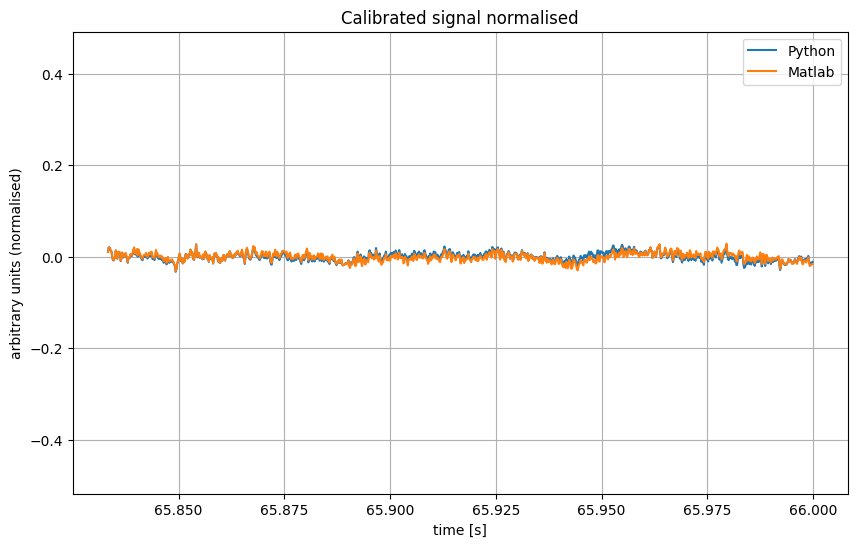

N1=431000, N2=432000
len(pyth)=1000
len(matl)=1000


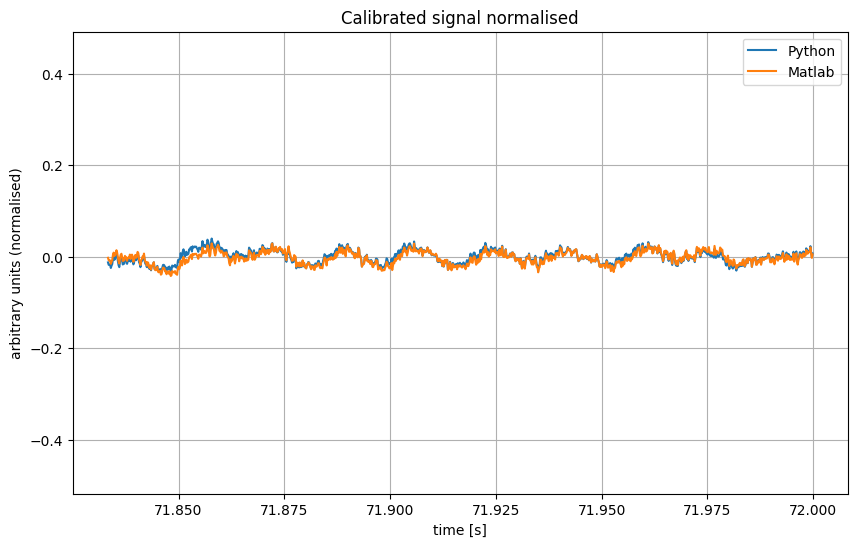

N1=467000, N2=468000
len(pyth)=1000
len(matl)=1000


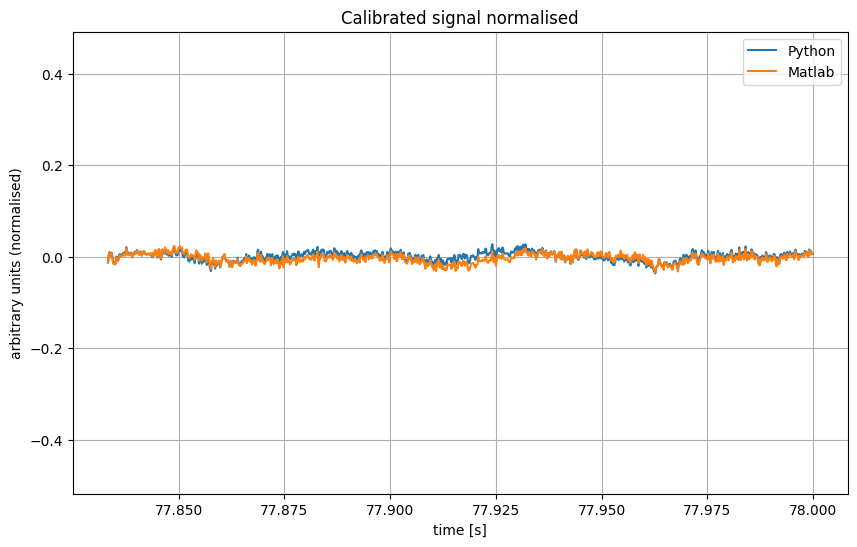

N1=503000, N2=504000
len(pyth)=1000
len(matl)=1000


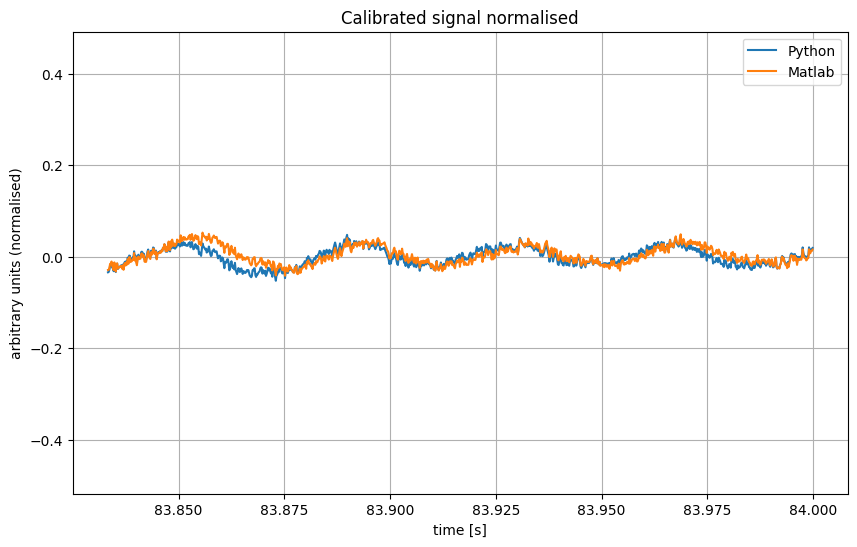

N1=539000, N2=540000
len(pyth)=1000
len(matl)=1000


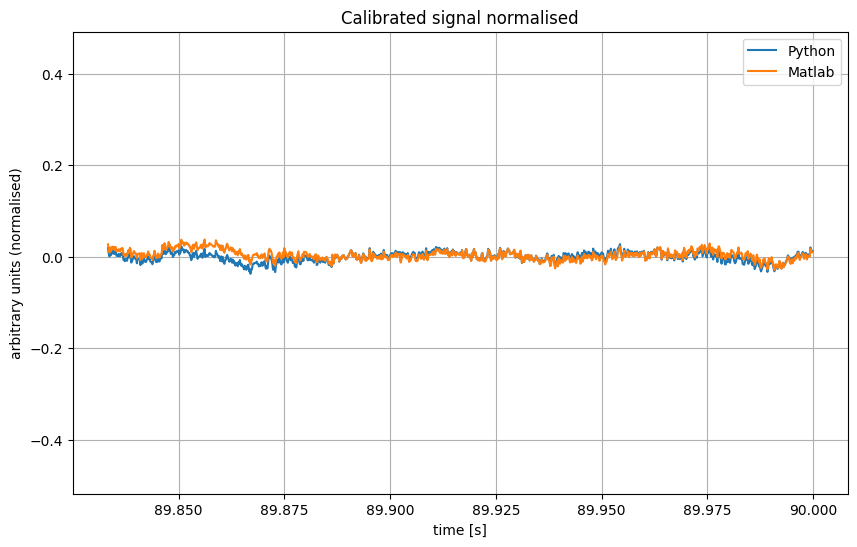

N1=575000, N2=576000
len(pyth)=1000
len(matl)=1000


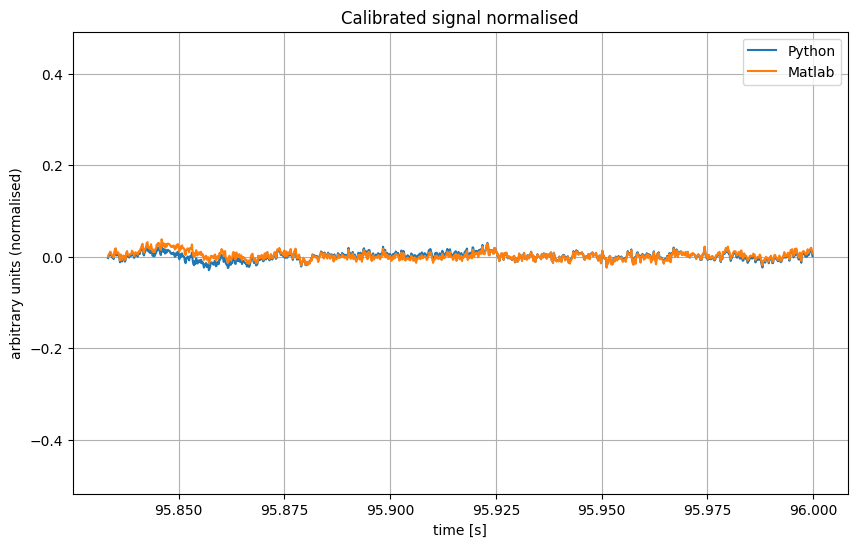

N1=611000, N2=612000
len(pyth)=1000
len(matl)=1000


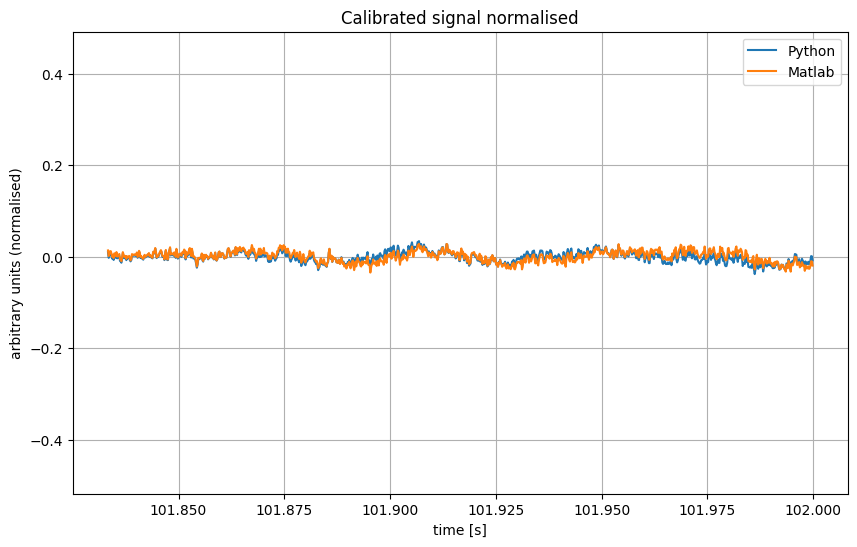

N1=647000, N2=648000
len(pyth)=1000
len(matl)=1000


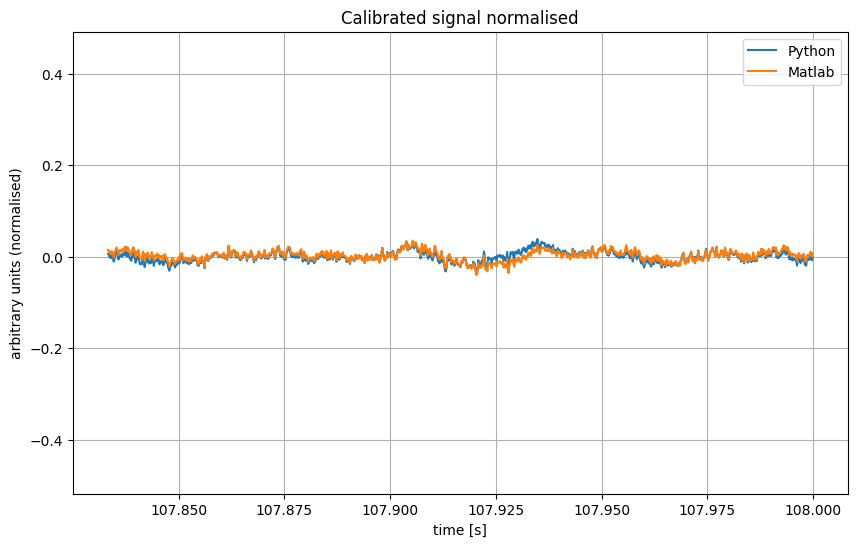

N1=683000, N2=684000
len(pyth)=1000
len(matl)=1000


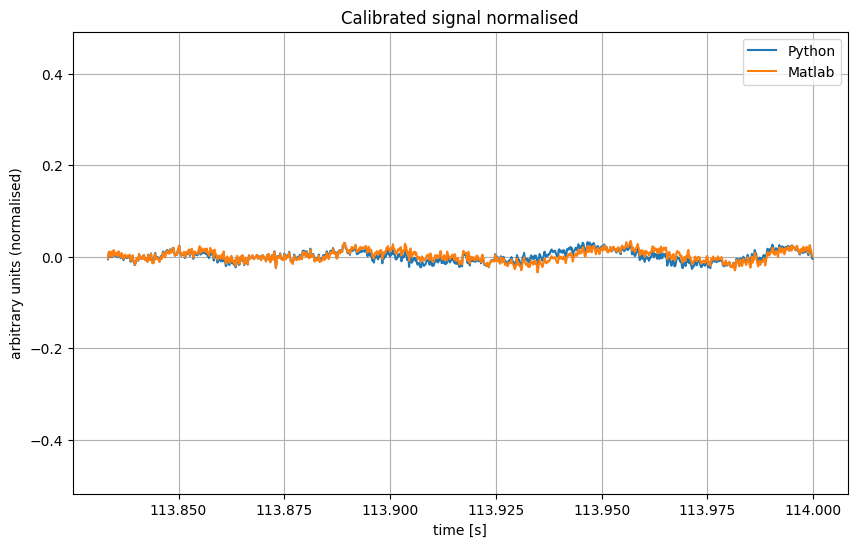

N1=719000, N2=720000
len(pyth)=1000
len(matl)=1000


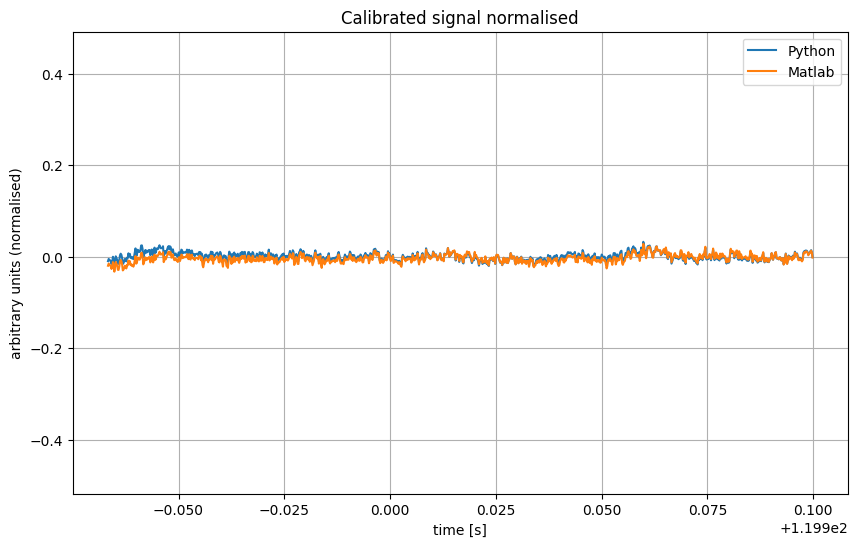

N1=755000, N2=756000
len(pyth)=1000
len(matl)=1000


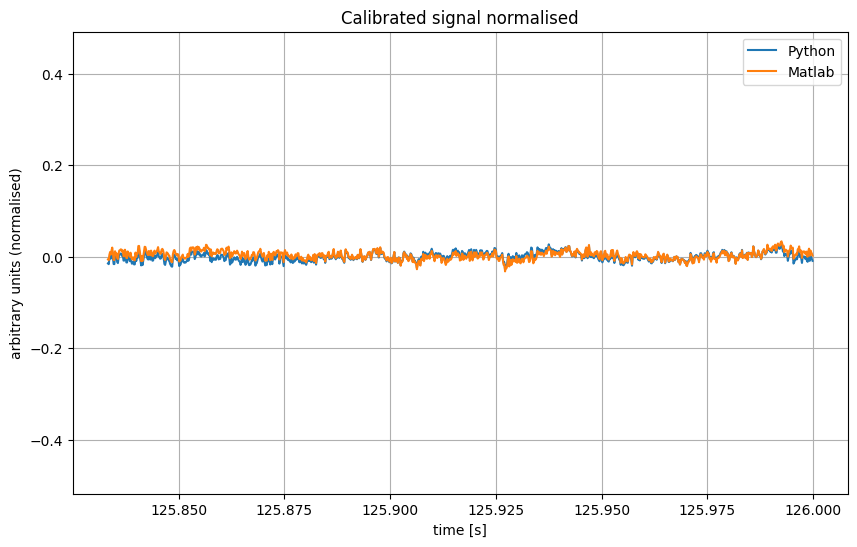

N1=791000, N2=792000
len(pyth)=1000
len(matl)=1000


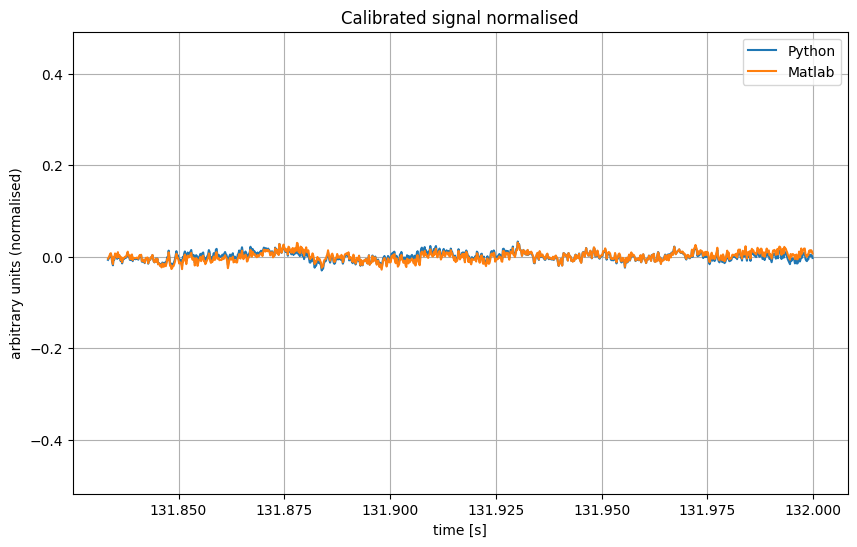

N1=827000, N2=828000
len(pyth)=1000
len(matl)=1000


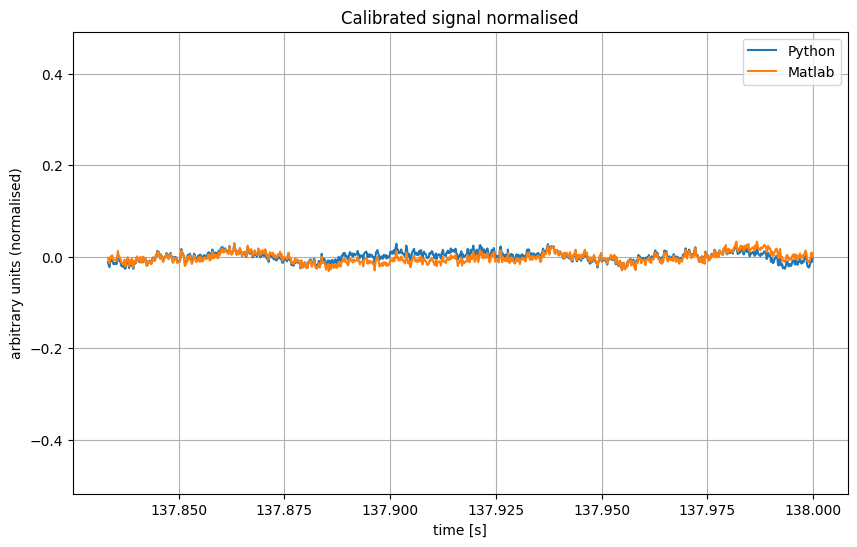

N1=863000, N2=864000
len(pyth)=1000
len(matl)=1000


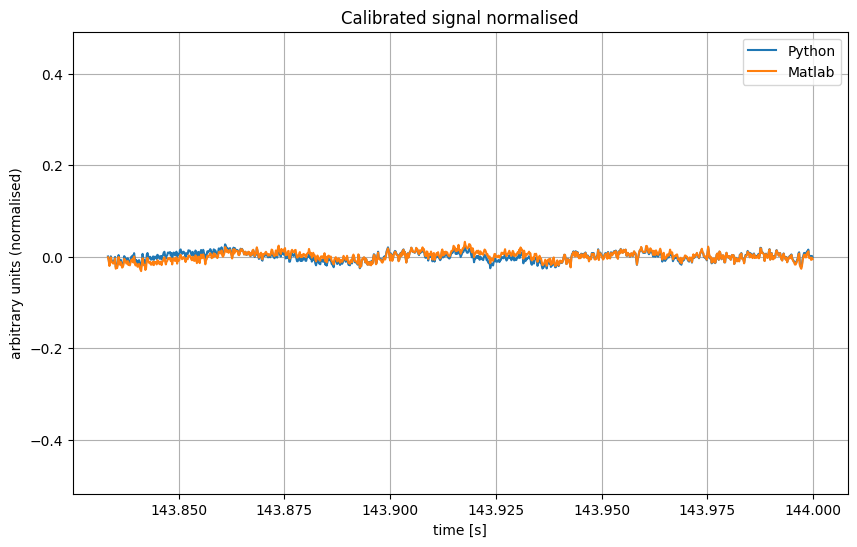

N1=899000, N2=900000
len(pyth)=1000
len(matl)=1000


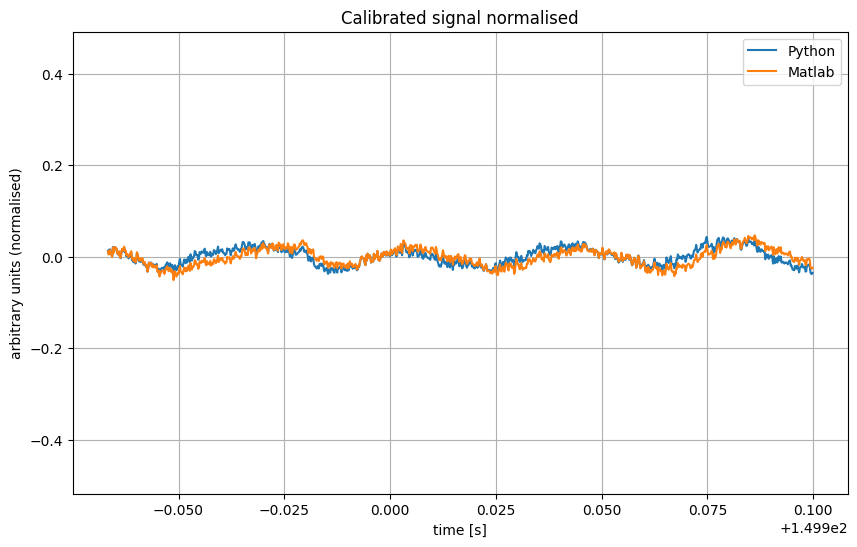

N1=935000, N2=936000
len(pyth)=1000
len(matl)=1000


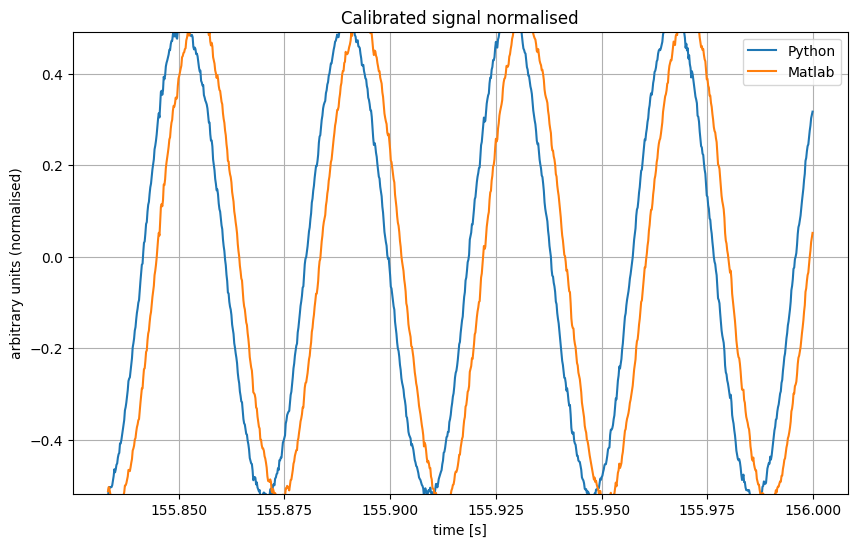

N1=971000, N2=972000
len(pyth)=1000
len(matl)=1000


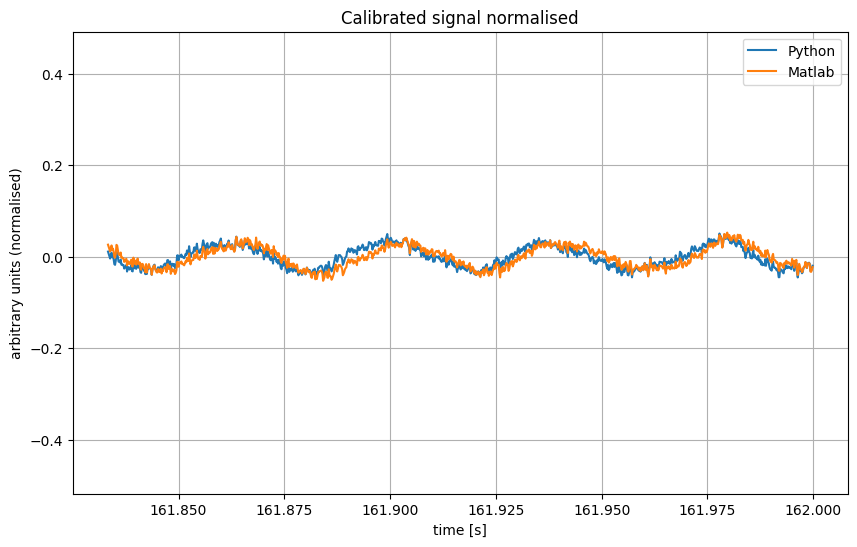

N1=1007000, N2=1008000
len(pyth)=1000
len(matl)=1000


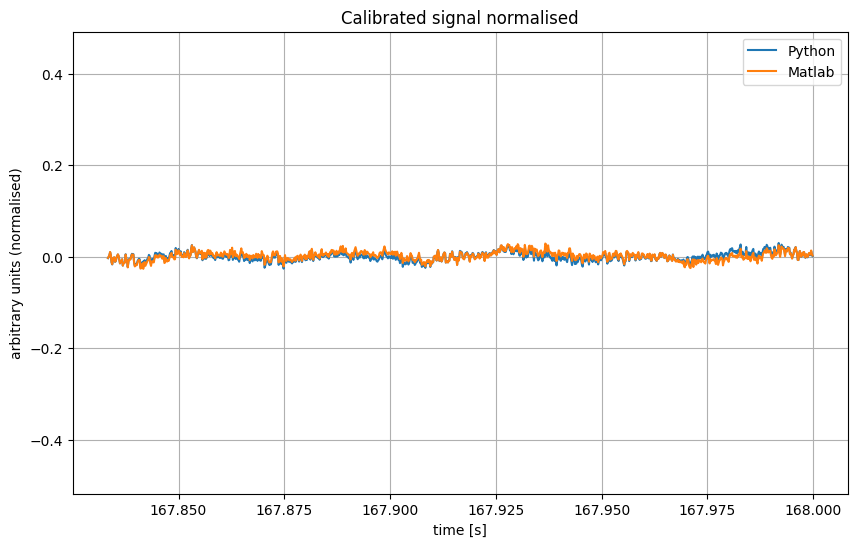

N1=1043000, N2=1044000
len(pyth)=1000
len(matl)=1000


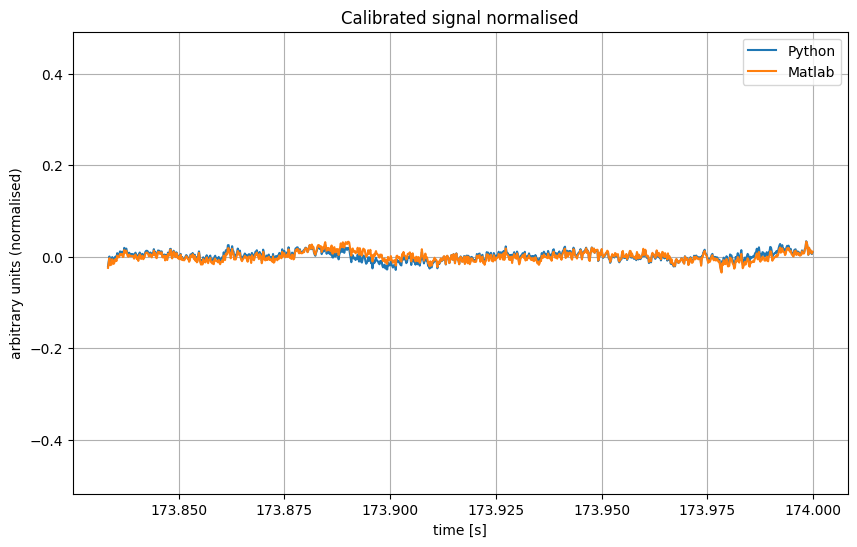

N1=1079000, N2=1080000
len(pyth)=1000
len(matl)=1000


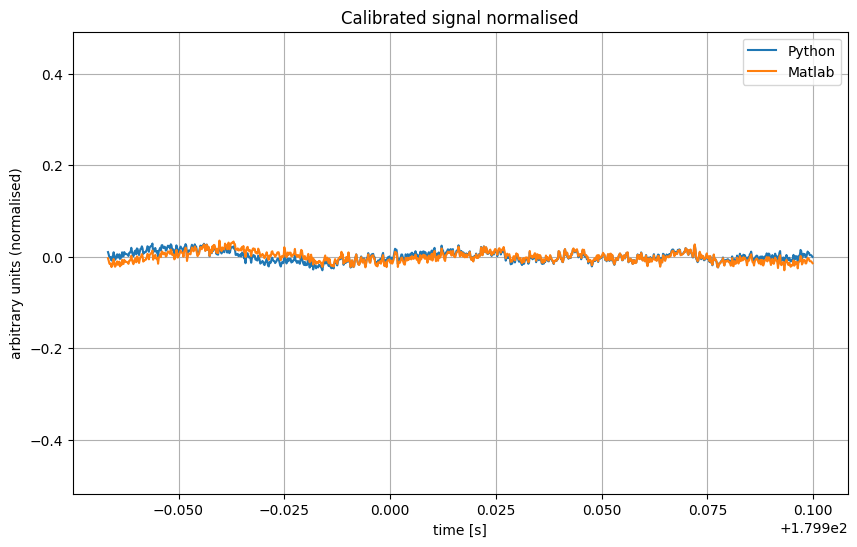

N1=1115000, N2=1116000
len(pyth)=1000
len(matl)=1000


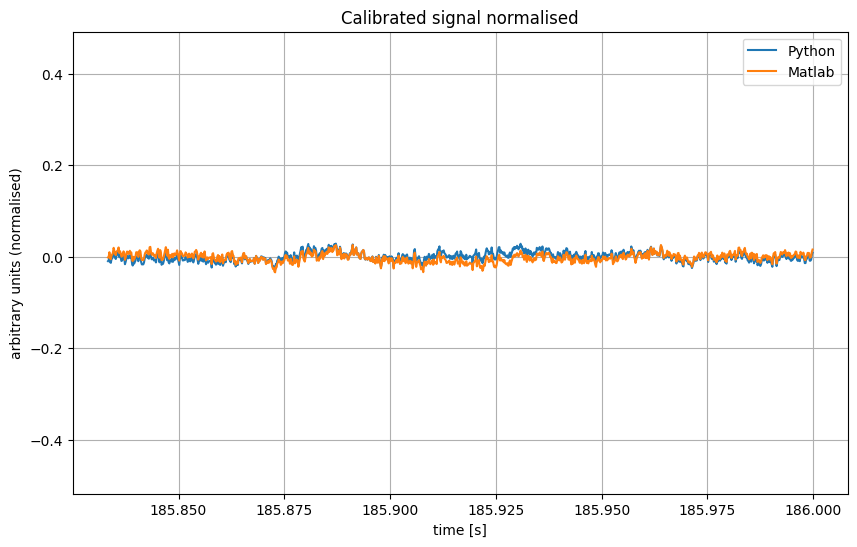

N1=1151000, N2=1152000
len(pyth)=1000
len(matl)=1000


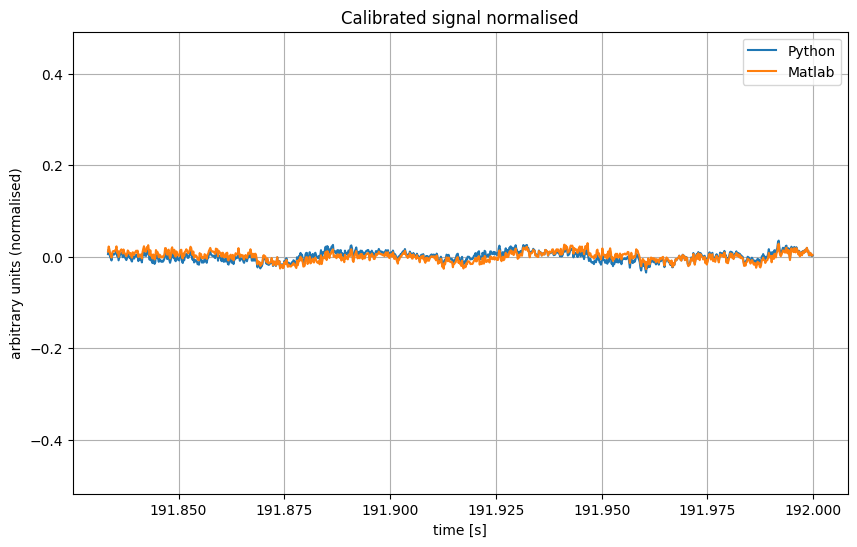

N1=1187000, N2=1188000
len(pyth)=1000
len(matl)=1000


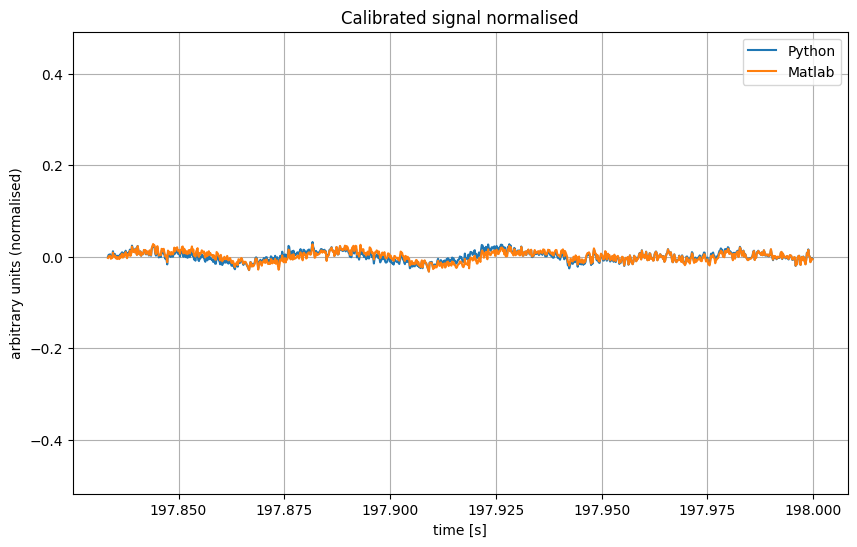

N1=1223000, N2=1224000
len(pyth)=1000
len(matl)=1000


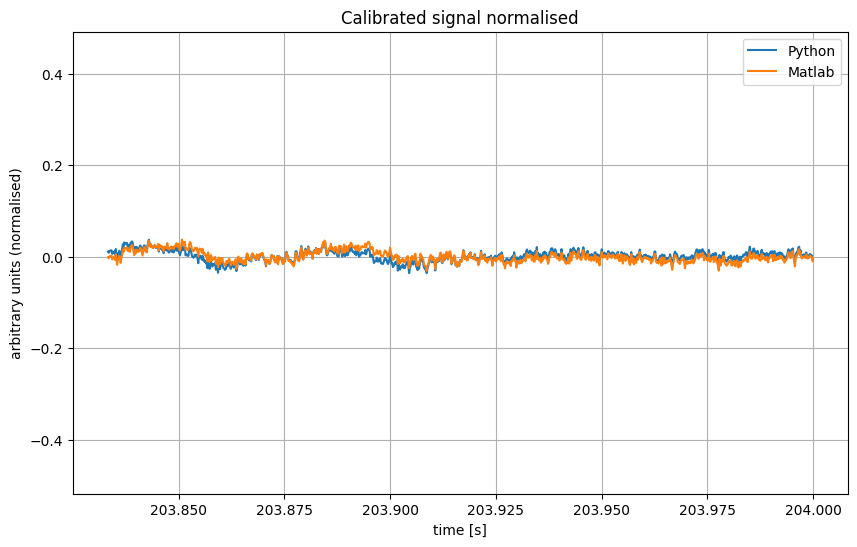

N1=1259000, N2=1260000
len(pyth)=1000
len(matl)=1000


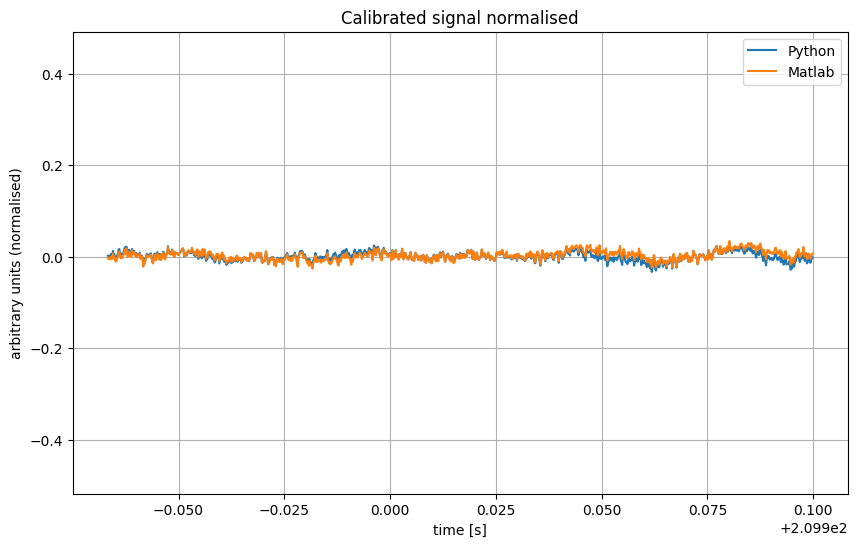

N1=1295000, N2=1296000
len(pyth)=1000
len(matl)=1000


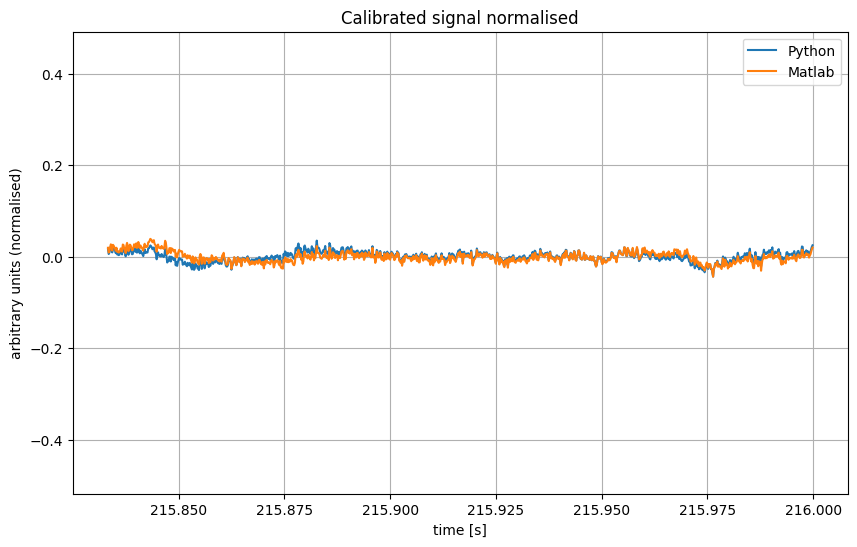

N1=1331000, N2=1332000
len(pyth)=1000
len(matl)=1000


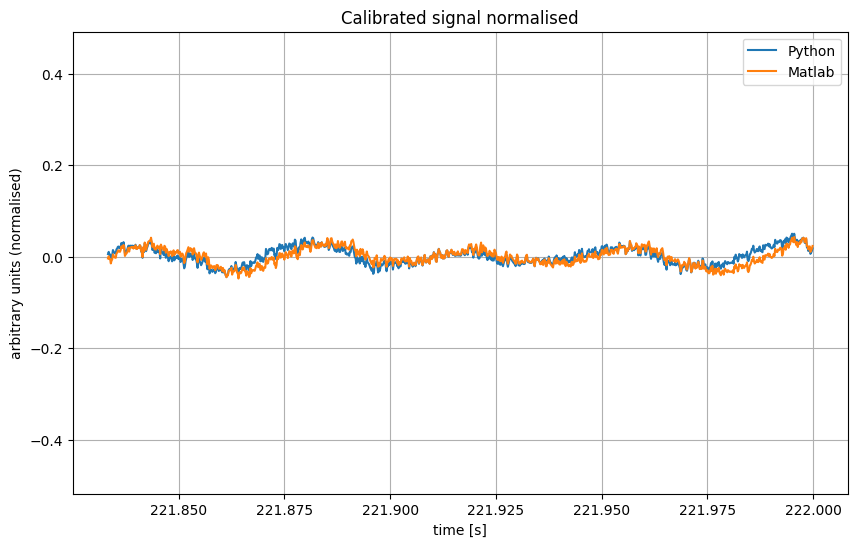

N1=1367000, N2=1368000
len(pyth)=1000
len(matl)=1000


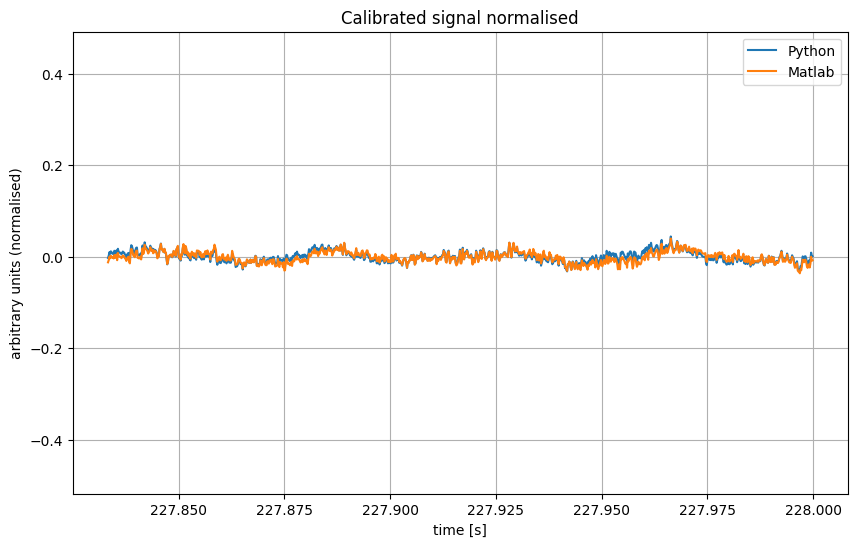

N1=1403000, N2=1404000
len(pyth)=1000
len(matl)=1000


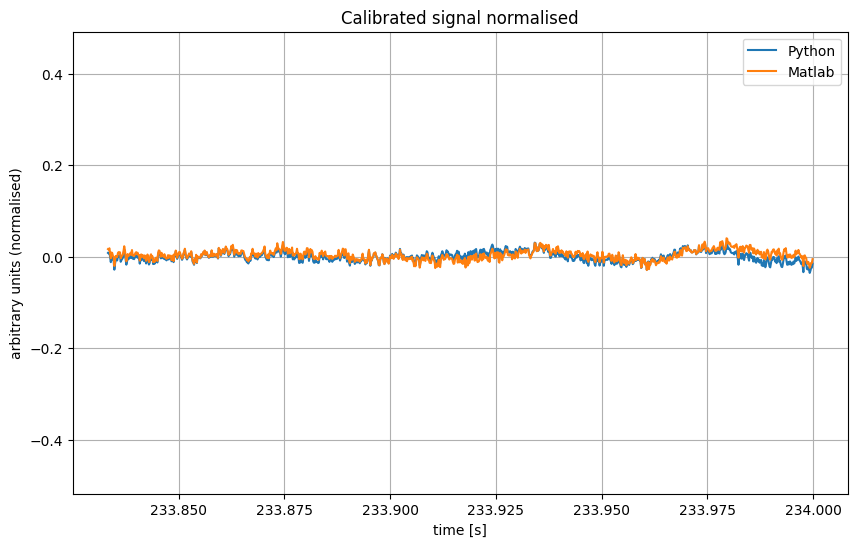

N1=1439000, N2=1440000
len(pyth)=1000
len(matl)=1000


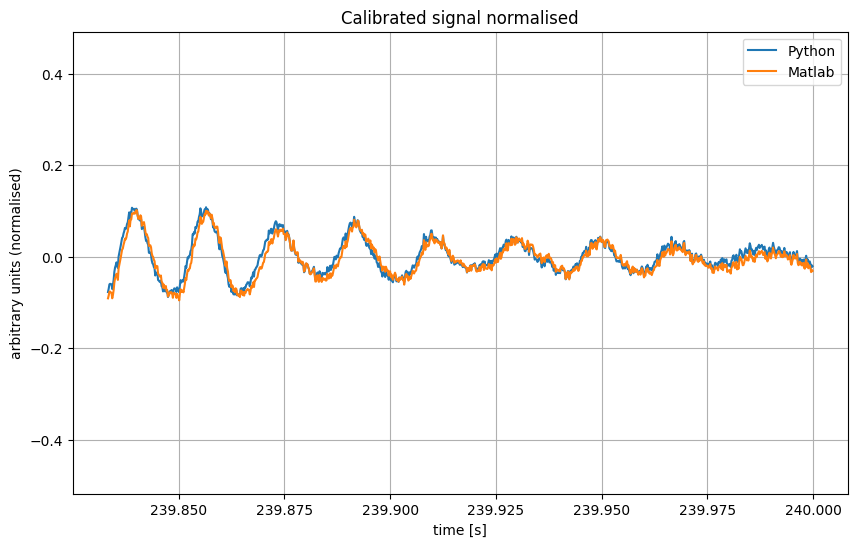

N1=1475000, N2=1476000
len(pyth)=1000
len(matl)=1000


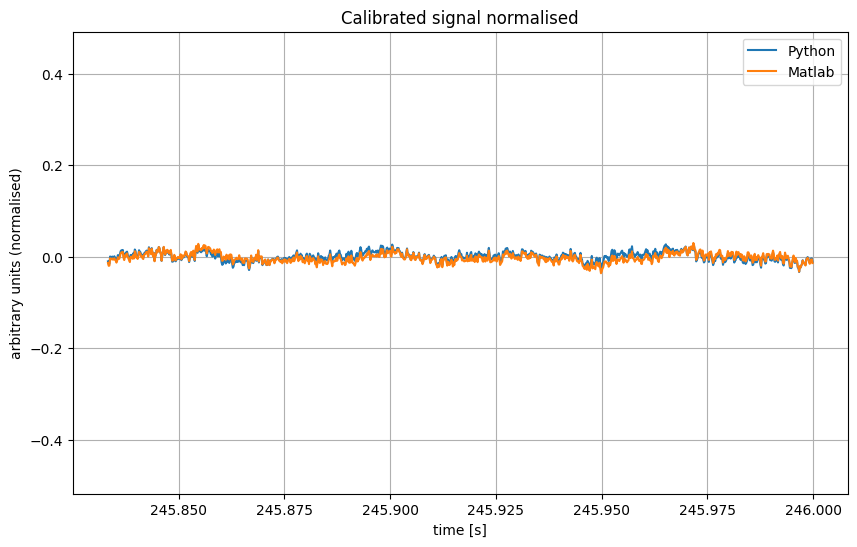

N1=1511000, N2=1512000
len(pyth)=1000
len(matl)=1000


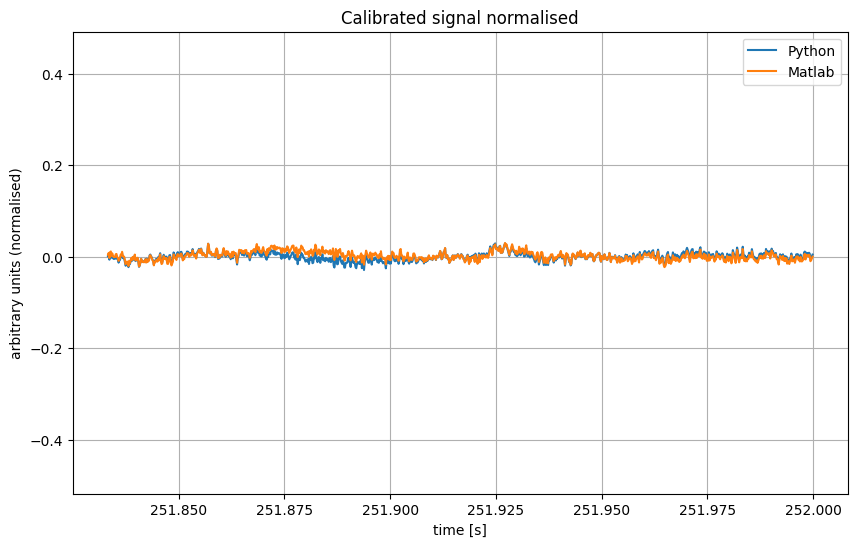

N1=1547000, N2=1548000
len(pyth)=1000
len(matl)=1000


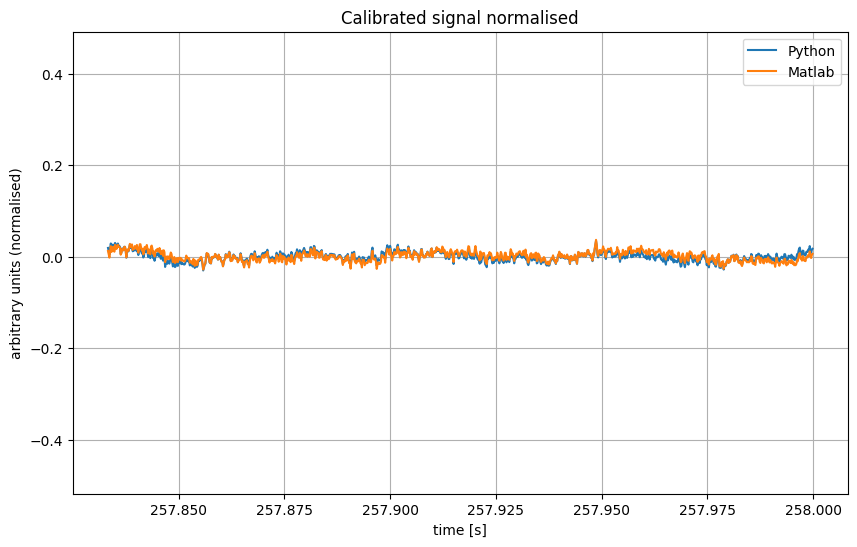

N1=1583000, N2=1584000
len(pyth)=1000
len(matl)=1000


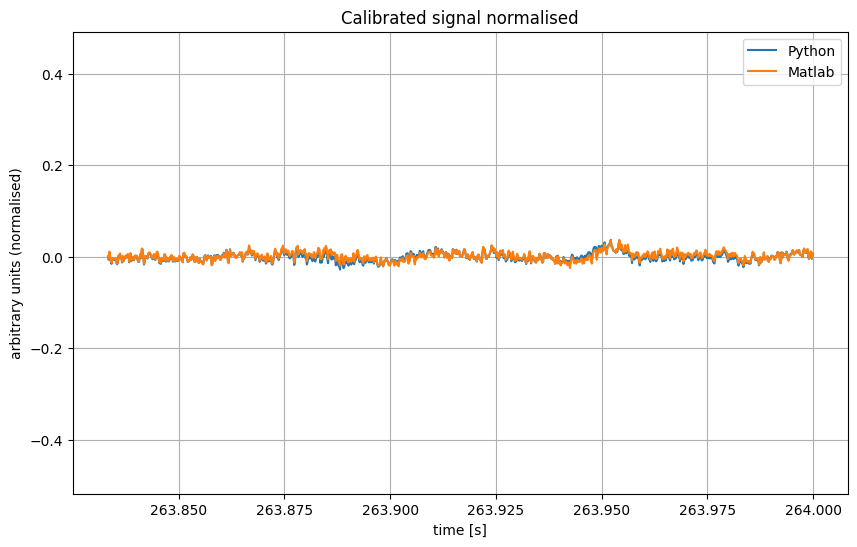

N1=1619000, N2=1620000
len(pyth)=1000
len(matl)=1000


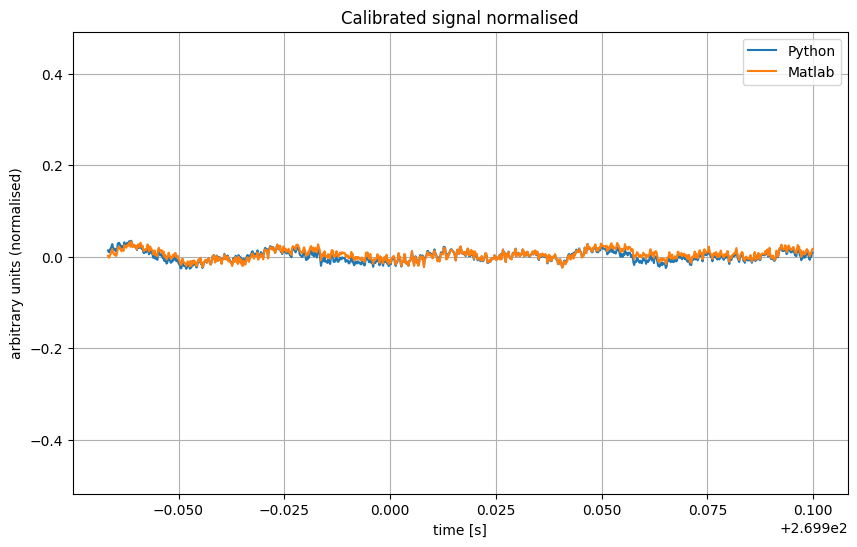

N1=1655000, N2=1656000
len(pyth)=1000
len(matl)=1000


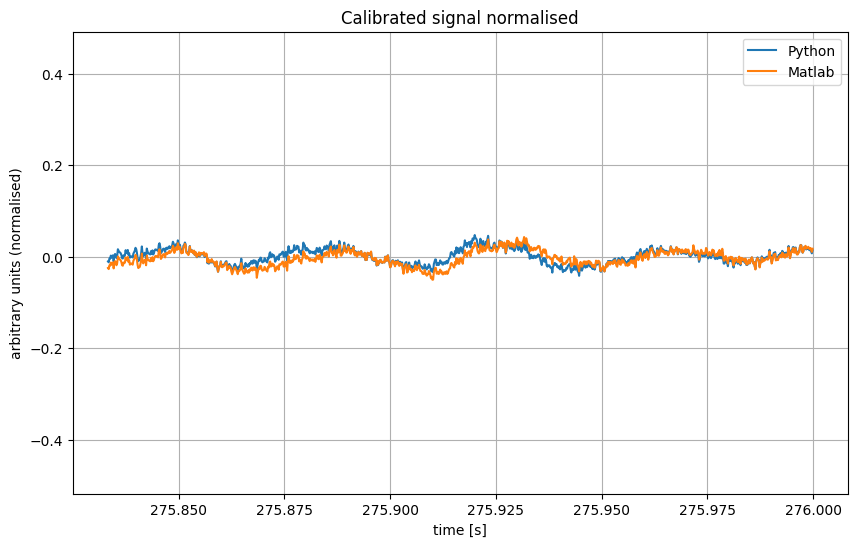

N1=1691000, N2=1692000
len(pyth)=1000
len(matl)=1000


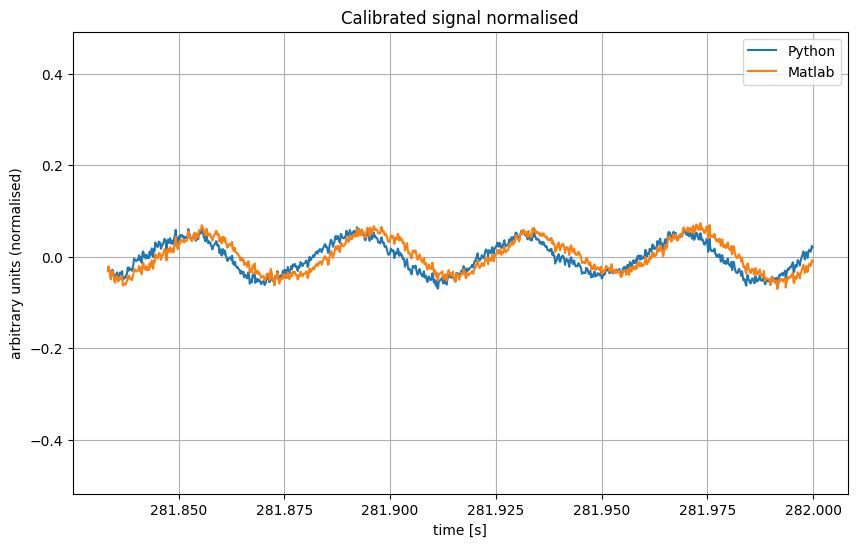

N1=1727000, N2=1728000
len(pyth)=1000
len(matl)=1000


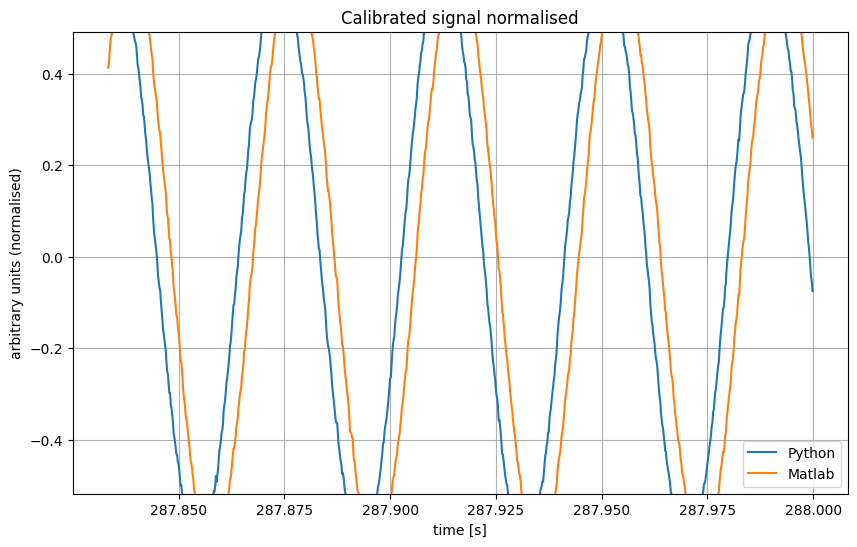

N1=1763000, N2=1764000
len(pyth)=1000
len(matl)=1000


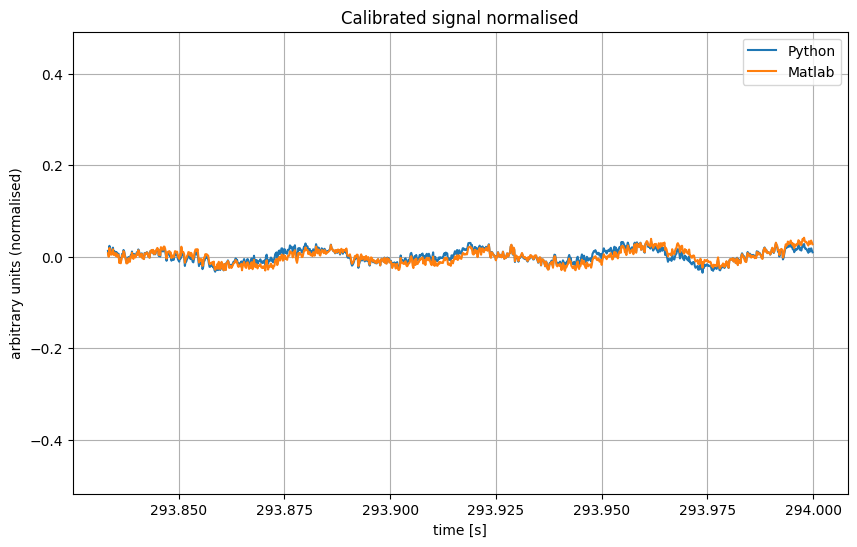

In [20]:
N1=0
N2=1000
x = numpy.arange(N1/sampleRate, N2/sampleRate, 1/sampleRate)
pyth = normalisedSignal[N1:N2]
matl = ref_normalised[N1:N2]
        
plt.figure(figsize=(10, 6))
plt.plot(x, pyth, linestyle='-', label='Python')
plt.plot(x, matl, linestyle='-', label='Matlab')
plt.xlabel('time [s]')
plt.ylabel('arbitrary units (normalised)')
plt.title('Calibrated signal normalised')
plt.legend()
y_min, y_max = plt.gca().get_ylim()
plt.grid(True)
plt.show()
# save the y scale limits of the plot

for n in numpy.arange(len(ref_normalised)/10, len(ref_normalised), len(ref_normalised)/50):
    N1 = (n - 1000).astype(numpy.int64)
    N2 = n.astype(numpy.int64)
    print(f"N1={N1}, N2={N2}")
    x = (numpy.arange(N1/sampleRate, N2/sampleRate, 1/sampleRate))[0:1000]
    pyth = normalisedSignal[N1:N2]
    print(f"len(pyth)={len(pyth)}")
    matl = ref_normalised[N1:N2]
    print(f"len(matl)={len(pyth)}")
        
    plt.figure(figsize=(10, 6))
    plt.plot(x, pyth, linestyle='-', label='Python')
    plt.plot(x, matl, linestyle='-', label='Matlab')
    plt.ylim(y_min, y_max)  # Set the y-axis limits to match the first plot
    plt.xlabel('time [s]')
    plt.ylabel('arbitrary units (normalised)')
    plt.title('Calibrated signal normalised')
    plt.legend()
    plt.grid(True)
    plt.show()


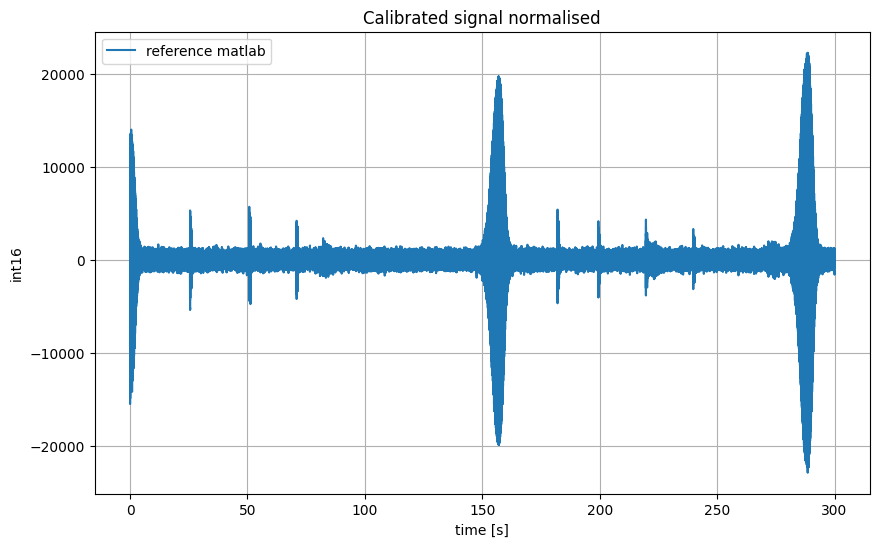

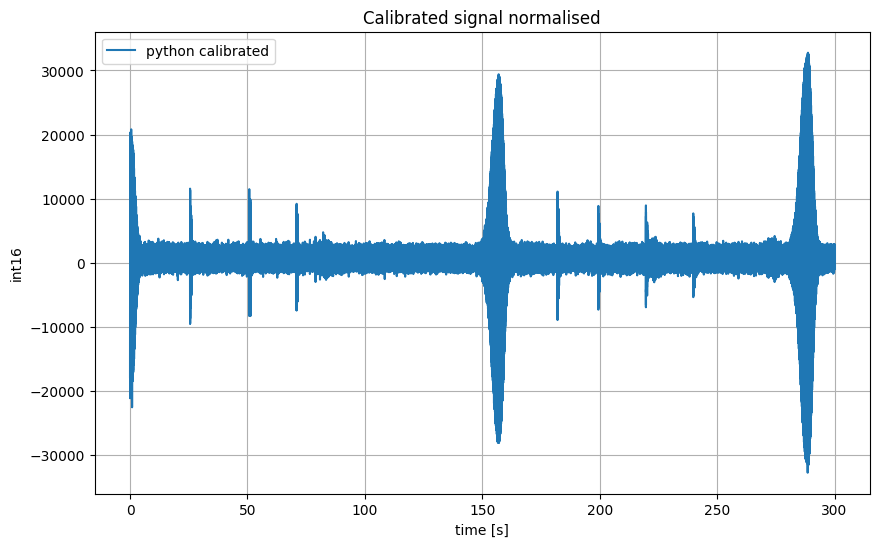

Binary conversion Bulgarian factor: 0.5534384573424258


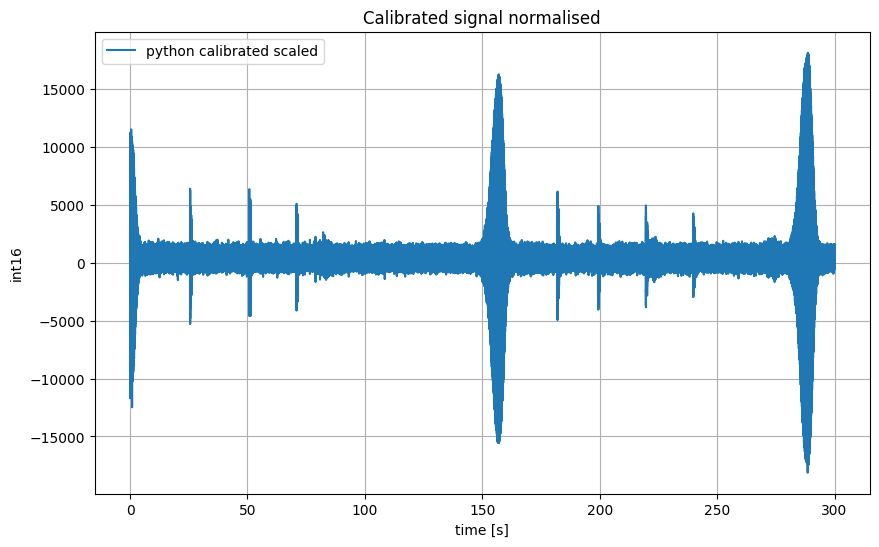

In [21]:
import wave
wav1 = '../tests/data/Rottnest_3154/502DB01D.wav'
ref1 = '../tests/data/Rottnest_3154/reference/502DB01D.wav'
# Open the first WAV file
with wave.open(wav1, 'rb') as wav_file1:
    params1 = wav_file1.getparams()
    frames1 = wav_file1.readframes(params1.nframes)
    samples1 = numpy.frombuffer(frames1, dtype=numpy.int16)
# Open the second WAV file (reference)
with wave.open(ref1, 'rb') as wav_file2:
    params2 = wav_file2.getparams()
    frames2 = wav_file2.readframes(params2.nframes)
    reference = numpy.frombuffer(frames2, dtype=numpy.int16)

x = numpy.arange(0, (reference.size)/sampleRate, (1/sampleRate))
pyth = samples1[0:len(reference)]

plt.figure(figsize=(10, 6))
plt.plot(x, reference, linestyle='-', label='reference matlab')
plt.xlabel('time [s]')
plt.ylabel('int16')
plt.title('Calibrated signal normalised')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(x, pyth, linestyle='-', label='python calibrated')
plt.xlabel('time [s]')
plt.ylabel('int16')
plt.title('Calibrated signal normalised')
plt.legend()
plt.grid(True)
plt.show()

factor = numpy.mean(numpy.abs(reference)) / numpy.mean(numpy.abs(pyth))
print(f"Binary conversion Bulgarian factor: {factor}")

plt.figure(figsize=(10, 6))
plt.plot(x, pyth*factor, linestyle='-', label='python calibrated scaled')
plt.xlabel('time [s]')
plt.ylabel('int16')
plt.title('Calibrated signal normalised')
plt.legend()
plt.grid(True)
plt.show()